# MSc Project. David Brookes, June-August 2020.


In [1]:
# Import libraries.
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy

import joblib

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


In [3]:
# To plot figures.
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
# Where to save the images.
PROJECT_ROOT_DIR = "."

def save_fig(IMAGE_Subfolder, fig_id, tight_layout=True, fig_extension="png", resolution=300):
    IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "Images", IMAGE_Subfolder)
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [6]:
# Where to save the models.
PROJECT_ROOT_DIR = "."
#MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "Models")

#os.makedirs(MODELS_PATH, exist_ok=True)

def save_model_and_results(model, results, MODEL_Subfolder, filename, extension="pkl"):
    MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "Models", MODEL_Subfolder)
    os.makedirs(MODELS_PATH, exist_ok=True)
    
    model_filename = filename + '+' + MODEL_Subfolder
    path = os.path.join(MODELS_PATH, model_filename + "." + extension)
    print("Saving model", model_filename)
    joblib.dump(model, path)
    
    results_filename = filename + '+' + 'results'
    path = os.path.join(MODELS_PATH, results_filename + "." + extension)
    print("Saving results", results_filename)
    joblib.dump(results, path)

def save_all_models_and_results(best_est_dict, cv_metrics_dict, MODEL_Subfolder):
    for y_var in response_variables:
        best_est = best_est_dict[y_var]
        cv_metrics = cv_metrics_dict[y_var]
        filename = y_var
        save_model_and_results(best_est, cv_metrics, MODEL_Subfolder, filename) 

    
def load_model_and_results(MODELS_Subfolder, filename, extension="pkl"):
    MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "Models", MODEL_Subfolder)  
    os.makedirs(MODELS_PATH, exist_ok=True)
    
    model_filename = filename + '+' + MODEL_Subfolder
    path = os.path.join(MODELS_PATH, model_filename + "." + extension)
    model_loaded = joblib.load(path)
    
    results_filename = filename + '+' + 'results'
    path = os.path.join(MODELS_PATH, results_filename + "." + extension)
    results_loaded = joblib.load(path)
    
    return(model_loaded, results_loaded)
    
def load_all_models_and_results(MODEL_Subfolder):
    best_estimators = []
    cv_metrics_all = []
    for y_var in response_variables:
        best_est, cv_metrics = load_model_and_results(MODEL_Subfolder, y_var)
        best_estimators.append(best_est)
        cv_metrics_all.append(cv_metrics)
    return(best_estimators, cv_metrics_all)

      

In [7]:
# Print current working directory (folder).
curr_dir=os.getcwd()
print(curr_dir)

C:\Users\David Brookes\Notebooks\MSc Project


In [8]:
# Change working directory.
# Note: 'r' allows backslashes (and forward slashes) in the file path name.
#curr_dir = os.chdir(r"D:\My Documents\Essex University\MSc Project\Electric Motor\Data set")
curr_dir = os.chdir(r"D:\My Documents\Essex University\MSc Project\Electric Motor")

In [8]:
# List the contents of the working directory.
#os.listdir(curr_dir)

In [9]:
# Read in the electric motor data. Store as a dataframe.
#
# Note: 'r' allows backslashes (and forward slashes) in the file path name.
motor_data = pd.read_csv(r"Data set\pmsm_temperature_data.csv")

In [10]:
# Use a sample of the data for testing purposes to save time.
# Set  FRAC to 1.0 to use all the data.
FRAC = 1.0

In [24]:
# Determine if there are any missing values.
motor_data.isnull().values.any()

False

In [25]:
# Count the number of NaNs each column has.
nans=pd.isnull(motor_data).sum()
nans[nans>0]

Series([], dtype: int64)

In [26]:
# Count the column types.
motor_data.dtypes.value_counts()

float64    12
int64       1
dtype: int64

In [11]:
# Print out the number of rows and columns in the dataframe.
motor_data.shape

(998070, 13)

In [28]:
# Print the first five rows of the data (head()).
motor_data.head()

ambient   coolant       u_d       u_q  motor_speed    torque       i_d  \
0 -0.752143 -1.118446  0.327935 -1.297858    -1.222428 -0.250182  1.029572   
1 -0.771263 -1.117021  0.329665 -1.297686    -1.222429 -0.249133  1.029509   
2 -0.782892 -1.116681  0.332771 -1.301822    -1.222428 -0.249431  1.029448   
3 -0.780935 -1.116764  0.333700 -1.301852    -1.222430 -0.248636  1.032845   
4 -0.774043 -1.116775  0.335206 -1.303118    -1.222429 -0.248701  1.031807   

        i_q        pm  stator_yoke  stator_tooth  stator_winding  profile_id  
0 -0.245860 -2.522071    -1.831422     -2.066143       -2.018033           4  
1 -0.245832 -2.522418    -1.830969     -2.064859       -2.017631           4  
2 -0.245818 -2.522673    -1.830400     -2.064073       -2.017343           4  
3 -0.246955 -2.521639    -1.830333     -2.063137       -2.017632           4  
4 -0.246610 -2.521900    -1.830498     -2.062795       -2.018145           4

# Session Lengths.

Saving figure session_lengths


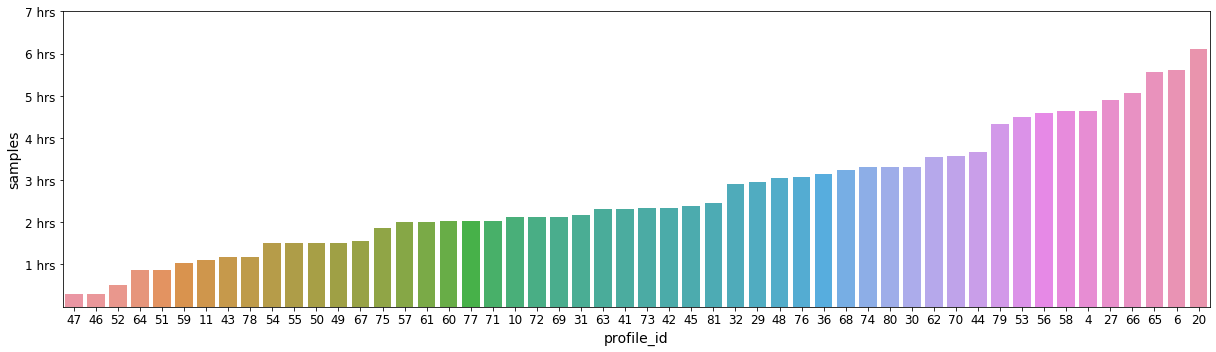

In [29]:
# Calculate the session lengths and sort into ascending order.

# Where to save the session lengths.
IMAGE_Subfolder = "Session lengths"

df=motor_data
fig = plt.figure(figsize=(17, 5))
grpd = df.groupby(['profile_id'])
_df = grpd.size().sort_values().rename('samples').reset_index()
ordered_ids = _df.profile_id.values.tolist()
sns.barplot(y='samples', x='profile_id', data=_df, order=ordered_ids)
tcks = plt.yticks(2*3600*np.arange(1, 8), [f'{a} hrs' for a in range(1, 8)]) # 2Hz sample rate
save_fig(IMAGE_Subfolder, "session_lengths")

In [17]:
# Print information on the motor data.
#motor_data.info()

In [12]:
# Drop the profile_id variable. This identifies the measurement sessions.
#
# Note: Carefully distinguishing between the profiles is only relevant if 
# training a model with memory capabilities, e.g. LSTM/GRU, or if using
# lag-features (e.g. implicitly with CNNs).

auxiliary_variables = ['profile_id']
drop_cols = auxiliary_variables
motor_data = motor_data.drop(drop_cols, axis=1)

#motor_data.info()

In [31]:
# Drop duplicate rows.
motor_data = motor_data.drop_duplicates(keep='first')
#motor_data.info()

In [13]:
# Print out the number of rows and columns in the dataframe.
motor_data.shape

(998070, 12)

In [21]:
# Print summary statistics
# The data has been normalised so that mean=0 and standard deviation=1 approximately.

motor_data.describe().T

count      mean       std       min       25%       50%  \
ambient         998070.0 -0.003905  0.993127 -8.573954 -0.599385  0.266157   
coolant         998070.0  0.004723  1.002423 -1.429349 -1.037925 -0.177187   
u_d             998070.0  0.004780  0.997878 -1.655373 -0.826359  0.267542   
u_q             998070.0 -0.005690  1.002330 -1.861463 -0.927390 -0.099818   
motor_speed     998070.0 -0.006336  1.001229 -1.371529 -0.951892 -0.140246   
torque          998070.0 -0.003333  0.997907 -3.345953 -0.266917 -0.187246   
i_d             998070.0  0.006043  0.998994 -3.245874 -0.756296  0.213935   
i_q             998070.0 -0.003194  0.997912 -3.341639 -0.257269 -0.190076   
pm              998070.0 -0.004396  0.995686 -2.631991 -0.672308  0.094367   
stator_yoke     998070.0  0.000609  1.001049 -1.834688 -0.747265 -0.057226   
stator_tooth    998070.0 -0.002208  0.999597 -2.066143 -0.761951  0.005085   
stator_winding  998070.0 -0.003935  0.998343 -2.019973 -0.725622  0.006536   

                     75%       max  
ambient         0.686675  2.967117  
coolant         0.650709  2.649032  
u_d             0.358491  2.274734  
u_q             0.852625  1.793498  
motor_speed     0.853584  2.024164  
torque          0.547171  3.016971  
i_d             1.013975  1.060937  
i_q             0.499260  2.914185  
pm              0.680691  2.917456  
stator_yoke     0.697344  2.449158  
stator_tooth    0.772239  2.326668  
stator_winding  0.725660  2.653781

In [14]:
# Assign more meaningful variable names to a list object.
column_fullnames = ['Ambient Temperature','Coolant Temperature','Voltage d-component','Voltage q-component','Motor Speed','Torque','Current d-component','Current q-component','Permanent Magnet Surface Temperature','Stator Yoke Temperature','Stator Tooth Temperature','Stator Winding Temperature']

column_shortnames = list(motor_data.columns)
print('column_shortnames', column_shortnames)

# This is a list of response (target) variables that need to be predicted.
response_variables = ['torque','pm','stator_yoke','stator_tooth','stator_winding']
print('response_variables', response_variables)

# Remember : auxiliary_variables = ['profile_id']

# Form a list of predictor (input) variables.
def generate_pred_vars(response_variables, auxiliary_variables, column_names):
    predictor_variables = column_names.copy()
    for el in response_variables+auxiliary_variables:
        if el in column_names:
            predictor_variables.remove(el)
    return(predictor_variables)

predictor_variables = generate_pred_vars(response_variables, auxiliary_variables, column_shortnames)

print('predictor_variables', predictor_variables)


column_shortnames ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'torque', 'i_d', 'i_q', 'pm', 'stator_yoke', 'stator_tooth', 'stator_winding']
response_variables ['torque', 'pm', 'stator_yoke', 'stator_tooth', 'stator_winding']
predictor_variables ['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']


# Histograms.

Saving figure ambient


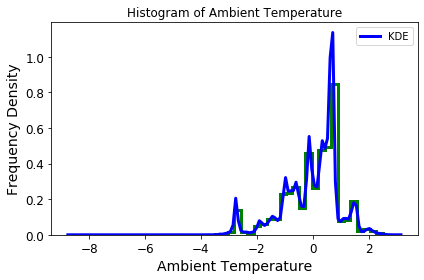

Saving figure coolant


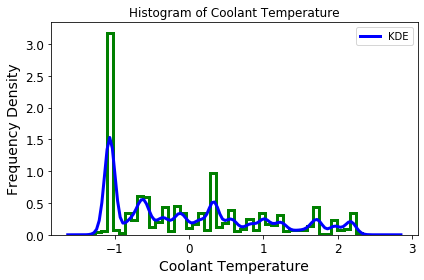

Saving figure u_d


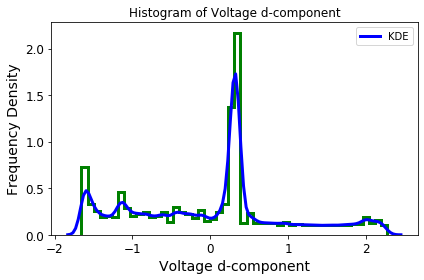

Saving figure u_q


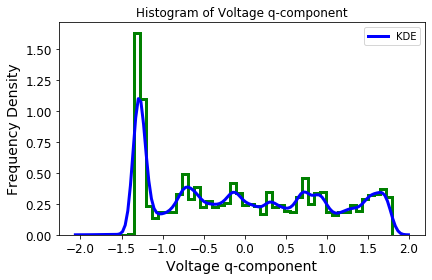

Saving figure motor_speed


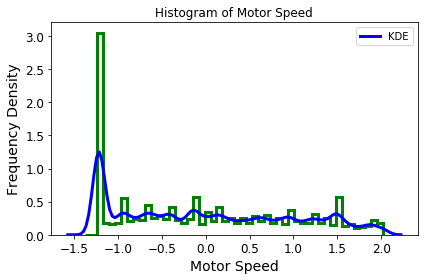

Saving figure torque


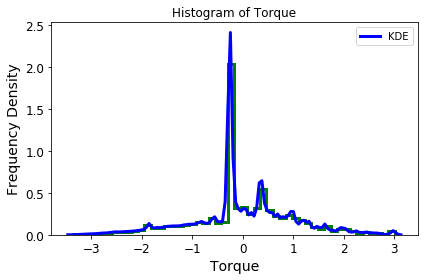

Saving figure i_d


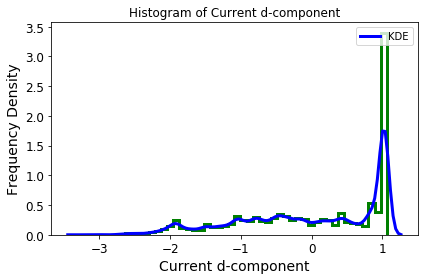

Saving figure i_q


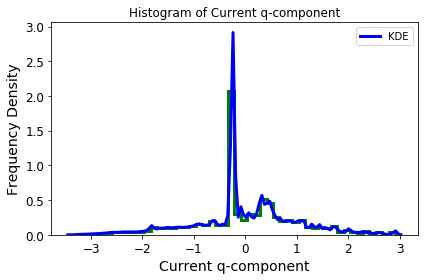

Saving figure pm


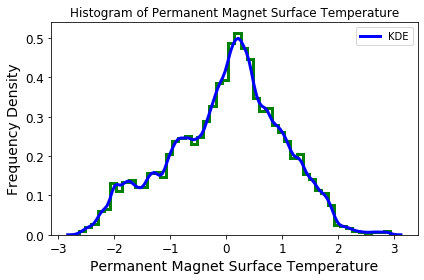

Saving figure stator_yoke


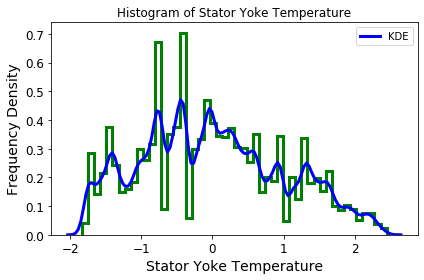

Saving figure stator_tooth


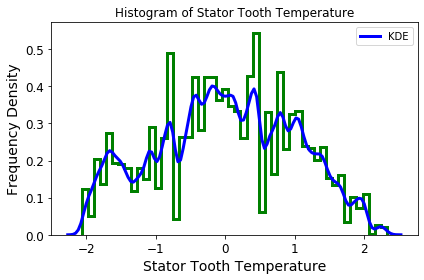

Saving figure stator_winding


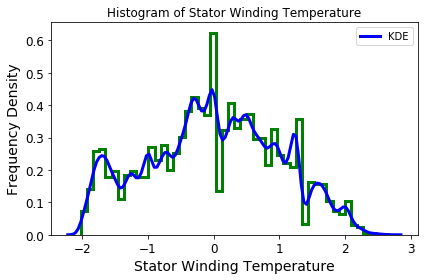

In [23]:
# Where to save the histograms.
IMAGE_Subfolder = "Histograms"

# Plot histogram of the variables, and also the kernel density estimate (KDE).
# Note: KDE is an estimate of the probabilty density function (pdf).

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use the ALL data.
sample_motor_data = motor_data.sample(frac = FRAC)

num_bins = 50
for i in range(0, len(sample_motor_data.columns)):
    
    sns.distplot(sample_motor_data[column_shortnames[i]], bins=num_bins, axlabel=column_fullnames[i],kde_kws={"color": "k", "linewidth": 3, "label": "KDE", "color": "b"},hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1, "color": "g"})
   
    plt.xlabel(column_fullnames[i])
    plt.ylabel('Frequency Density')
    plt.title('Histogram of '+ column_fullnames[i])
    
    save_fig(IMAGE_Subfolder, column_shortnames[i])
    
    plt.show()

# Quantile-Quantile plots.

Ambient Temperature ( ambient )
Saving figure ambient


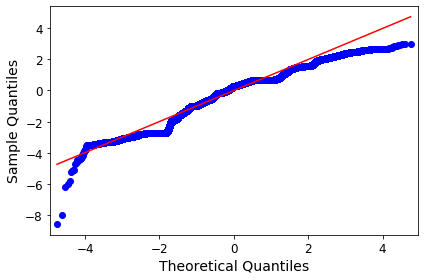

Coolant Temperature ( coolant )
Saving figure coolant


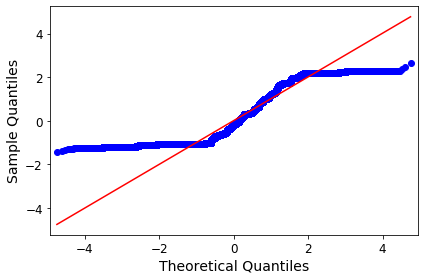

Voltage d-component ( u_d )
Saving figure u_d


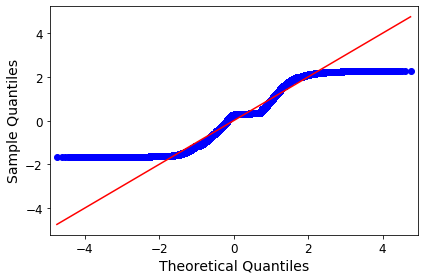

Voltage q-component ( u_q )
Saving figure u_q


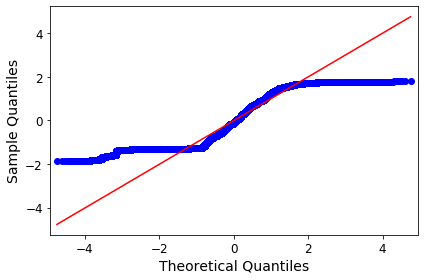

Motor Speed ( motor_speed )
Saving figure motor_speed


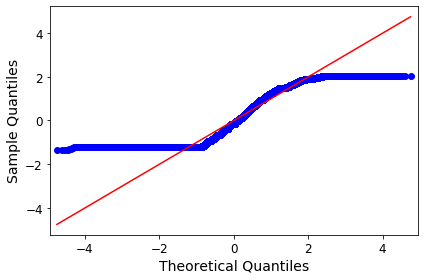

Torque ( torque )
Saving figure torque


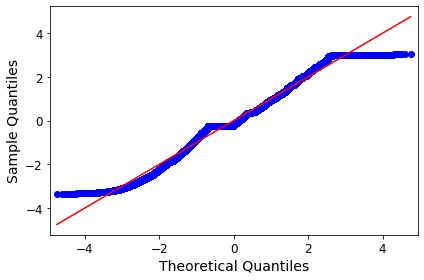

Current d-component ( i_d )
Saving figure i_d


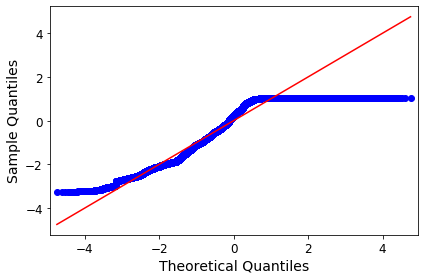

Current q-component ( i_q )
Saving figure i_q


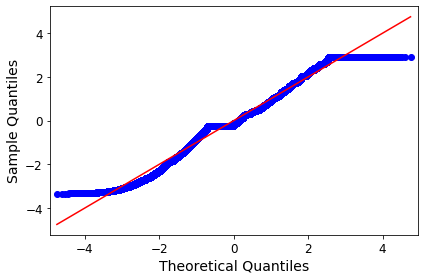

Permanent Magnet Surface Temperature ( pm )
Saving figure pm


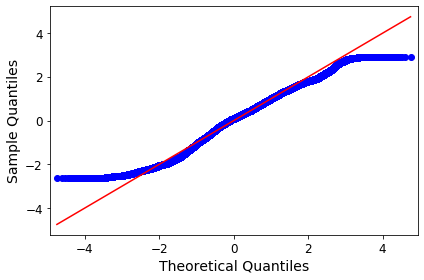

Stator Yoke Temperature ( stator_yoke )
Saving figure stator_yoke


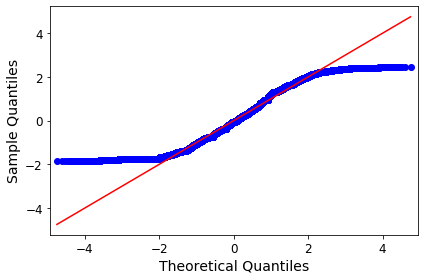

Stator Tooth Temperature ( stator_tooth )
Saving figure stator_tooth


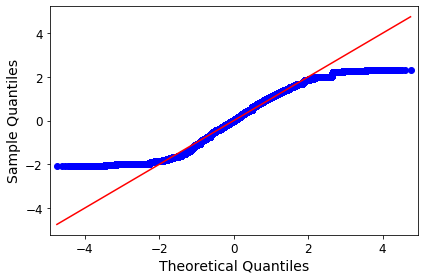

Stator Winding Temperature ( stator_winding )
Saving figure stator_winding


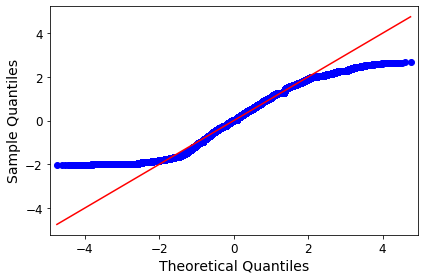

In [24]:
# Quantile-Quantile plots for the variables.
# The standard normal distribtion is the comparison distribution.

# Where to save the QQ plots.
IMAGE_Subfolder = "QQ"

import numpy as np
import statsmodels.api as sm
import pylab

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use the ALL data.
sample_motor_data = motor_data.sample(frac = FRAC)

for var in column_shortnames:
    index = column_shortnames.index(var)
    print(column_fullnames[index],'(',var,')')
    #sm.qqplot(motor_data[var], line='45')
    sm.qqplot(sample_motor_data[var], line='s')
    save_fig(IMAGE_Subfolder, var)
    pylab.show()

# Correlation Matrix.

In [81]:
# Produce a correlation matrix.

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use the ALL data.
sample_motor_data = motor_data.sample(frac = FRAC)

sample_motor_data_corr = sample_motor_data.corr()
#print(sample_motor_data_corr)


# Correlation Map.

Saving figure correlation_map


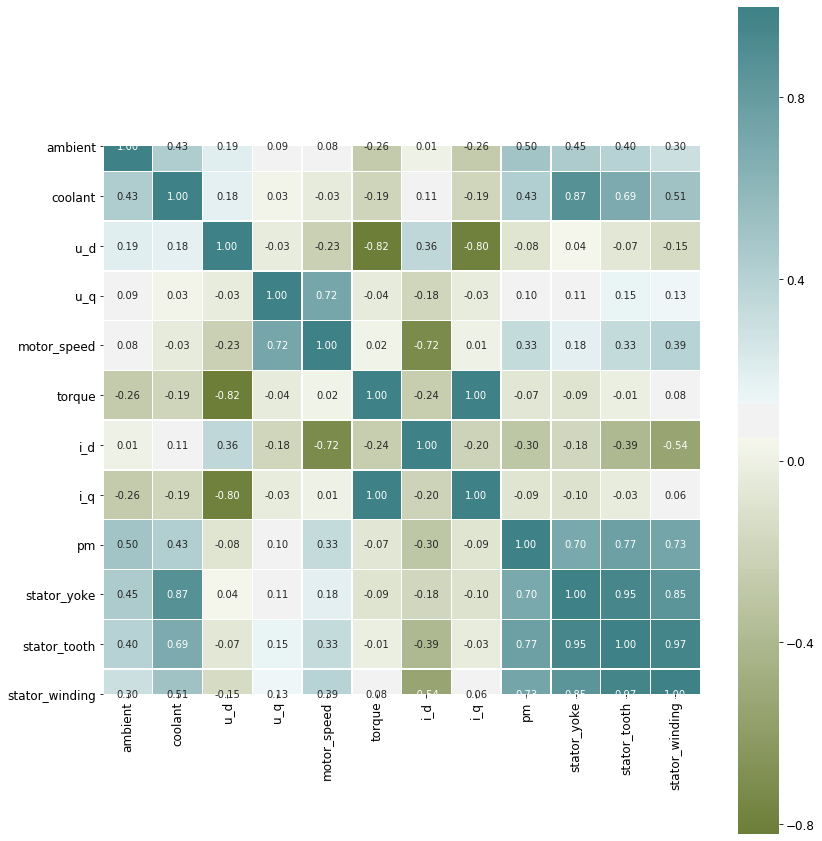

In [26]:
# Correlation map.

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use the ALL data.
sample_motor_data = motor_data.sample(frac = FRAC)

# Where to save the correlation map.
IMAGE_Subfolder = "Correlation"

f,ax=plt.subplots(figsize=(12,12))

sample_motor_data_corr=sample_motor_data.corr()

sns.heatmap(sample_motor_data_corr, annot=True, linewidths=.5, fmt='.2f', 
            mask= np.zeros_like(sample_motor_data_corr,dtype=np.bool), 
            cmap=sns.diverging_palette(100,200,as_cmap=True), 
            square=True, ax=ax)
save_fig(IMAGE_Subfolder, "correlation_map")

plt.show()

# Boxplots All.

Saving figure boxplots_all


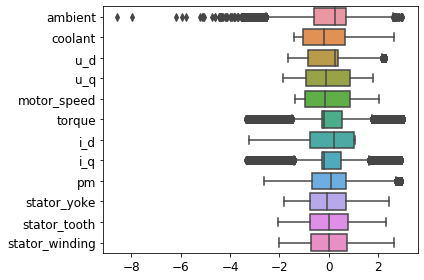

In [27]:
# Print boxplots of variables.

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use the ALL data.
sample_motor_data = motor_data.sample(frac = FRAC)

# Where to save the boxplots.
IMAGE_Subfolder = "Boxplots All"

box_plot_motors = sns.boxplot(data=sample_motor_data, orient='h')
save_fig(IMAGE_Subfolder, "boxplots_all")

# Boxplots Individual.

Saving figure ambient


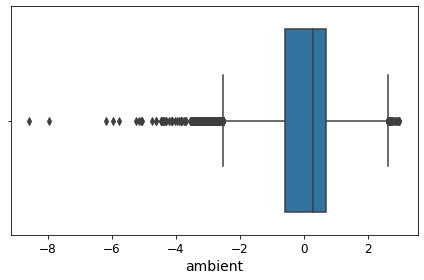

Saving figure coolant


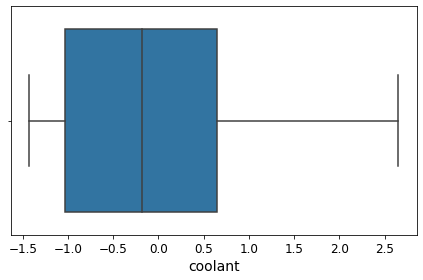

Saving figure u_d


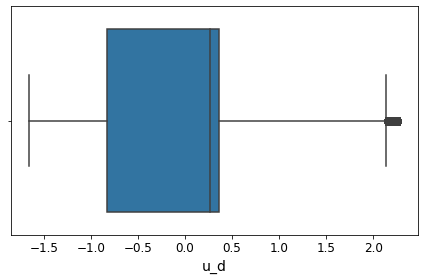

Saving figure u_q


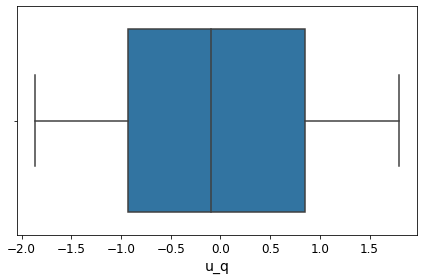

Saving figure motor_speed


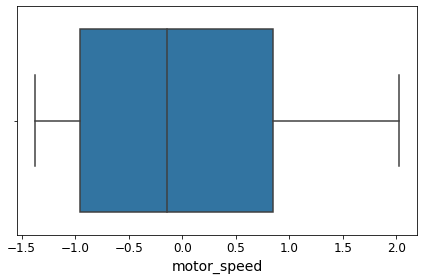

Saving figure torque


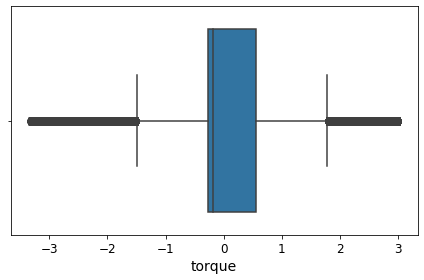

Saving figure i_d


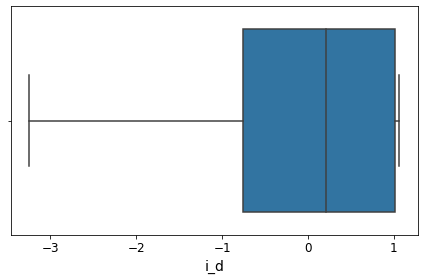

Saving figure i_q


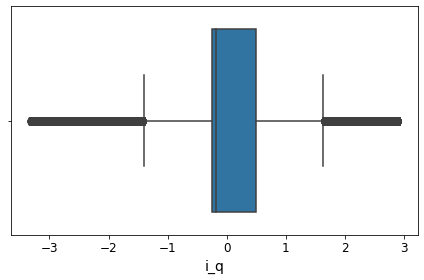

Saving figure pm


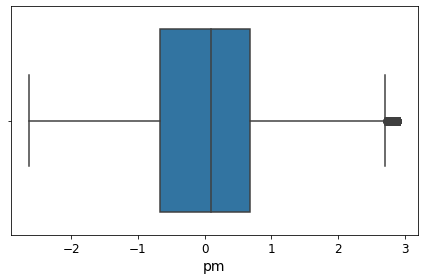

Saving figure stator_yoke


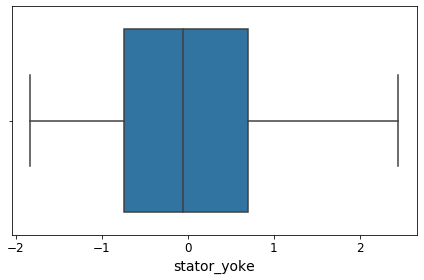

Saving figure stator_tooth


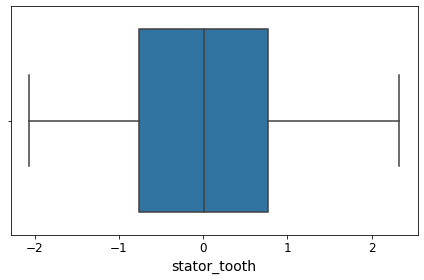

Saving figure stator_winding


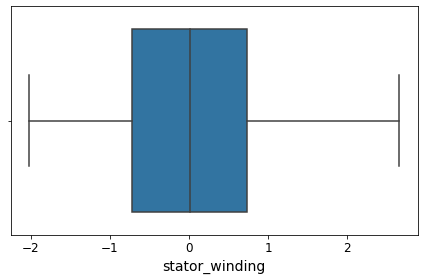

In [28]:
# Print boxplots of variables.

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use the ALL data.
sample_motor_data = motor_data.sample(frac = FRAC)

# Where to save the boxplots.
IMAGE_Subfolder = "Boxplots Individual"

for i in range(0, len(sample_motor_data.columns)):
    sns.boxplot(x=sample_motor_data.columns[i],data=sample_motor_data, orient='h')
    save_fig(IMAGE_Subfolder, sample_motor_data.columns[i])
    plt.show()
 

# Simple Linear Regression.

In [29]:
# Simple linear regression.  (Using statsmodels.api).
# 5 models considered.
# Response variables:
# 'torque' Torque induced by current.
# 'pm' (Permanent Magnet surface temperature - representing the rotor temperature).
# 'stator_yoke' (Stator yoke temperature measured with a thermal sensor)
# 'stator_tooth' (Stator tooth temperature measured with a thermal sensor)
# 'stator_winding' (Stator winding temperature measured with a thermal sensor)

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import f
import statsmodels.api as sm # Loaded in order to calculate the starndard error of the estimators (coefficients).
from sklearn.model_selection import KFold # Used for K fold cross validation.
from statistics import mean, variance, stdev 

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use the ALL data.
sample_motor_data = motor_data.sample(frac = FRAC)

for y_var in response_variables:
    
    y = sample_motor_data[y_var]
    #print(y)
    
    for x_var in predictor_variables:
        print('Response variable:  ', y_var)
        print('Predictor variable: ', x_var)
        
        x = sample_motor_data[x_var]
        # Create design matrix x_1.
        x_1 = sm.add_constant(x) # Add a column of 1s.

   
        # Fit a linear model and display the results.
        lm=sm.OLS(y, x_1)
        model=lm.fit()
        print(model.summary())  
        print(' ')
    


Response variable:   torque
Predictor variable:  ambient


C:\Users\David Brookes\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                 torque   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                 7.372e+04
Date:                Tue, 18 Aug 2020   Prob (F-statistic):               0.00
Time:                        18:26:57   Log-Likelihood:            -1.3785e+06
No. Observations:              998070   AIC:                         2.757e+06
Df Residuals:                  998068   BIC:                         2.757e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0044      0.001     -4.525      0.0

Response variable:   torque
Predictor variable:  ambient
Saving figure torque_vs_ambient


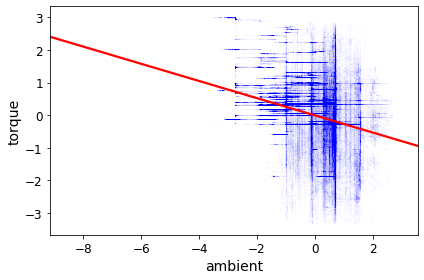

Response variable:   torque
Predictor variable:  coolant
Saving figure torque_vs_coolant


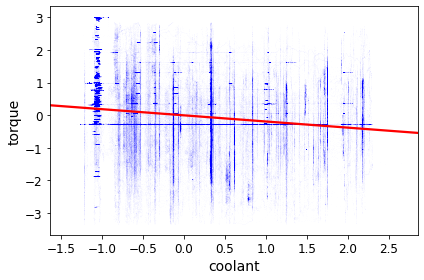

Response variable:   torque
Predictor variable:  u_d
Saving figure torque_vs_u_d


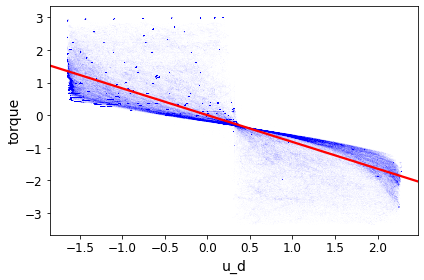

Response variable:   torque
Predictor variable:  u_q
Saving figure torque_vs_u_q


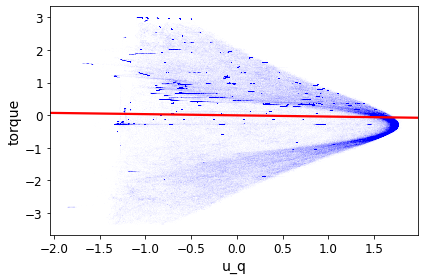

Response variable:   torque
Predictor variable:  motor_speed
Saving figure torque_vs_motor_speed


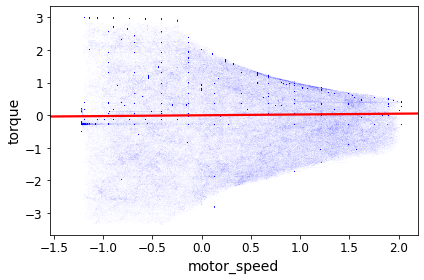

Response variable:   torque
Predictor variable:  i_d
Saving figure torque_vs_i_d


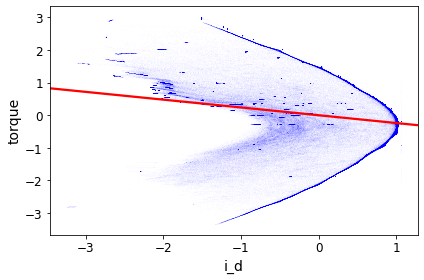

Response variable:   torque
Predictor variable:  i_q
Saving figure torque_vs_i_q


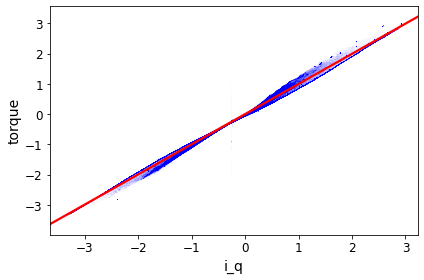

Response variable:   pm
Predictor variable:  ambient
Saving figure pm_vs_ambient


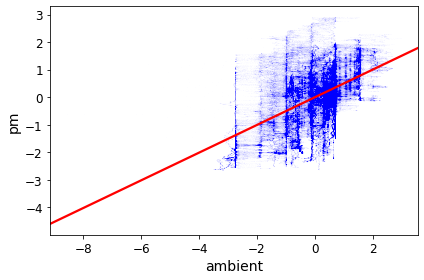

Response variable:   pm
Predictor variable:  coolant
Saving figure pm_vs_coolant


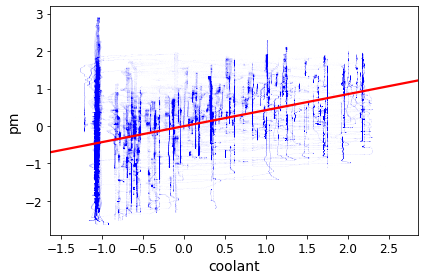

Response variable:   pm
Predictor variable:  u_d
Saving figure pm_vs_u_d


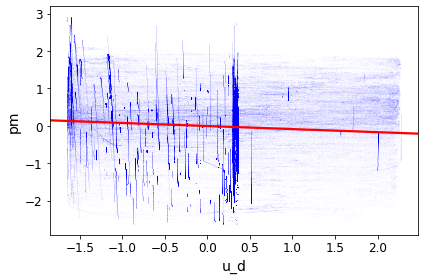

Response variable:   pm
Predictor variable:  u_q
Saving figure pm_vs_u_q


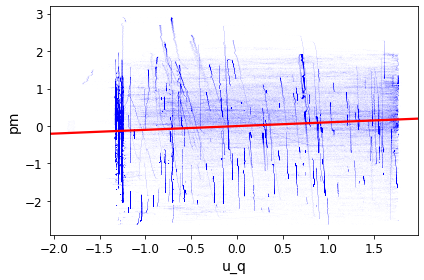

Response variable:   pm
Predictor variable:  motor_speed
Saving figure pm_vs_motor_speed


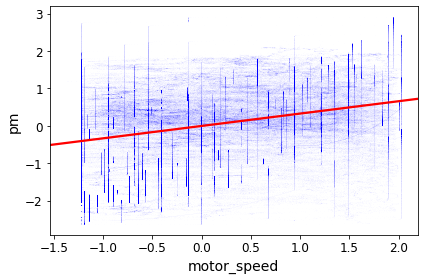

Response variable:   pm
Predictor variable:  i_d
Saving figure pm_vs_i_d


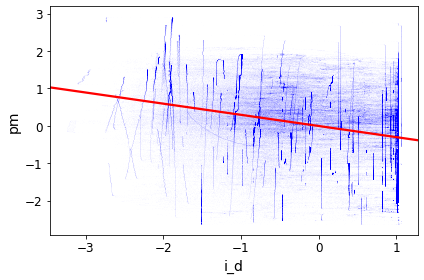

Response variable:   pm
Predictor variable:  i_q
Saving figure pm_vs_i_q


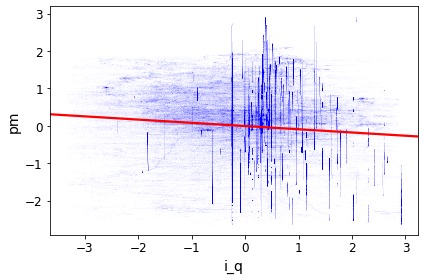

Response variable:   stator_yoke
Predictor variable:  ambient
Saving figure stator_yoke_vs_ambient


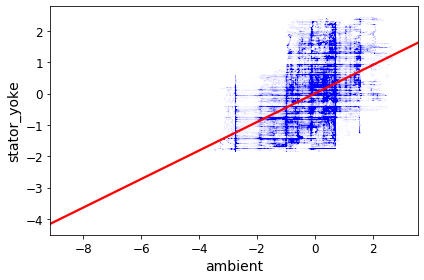

Response variable:   stator_yoke
Predictor variable:  coolant
Saving figure stator_yoke_vs_coolant


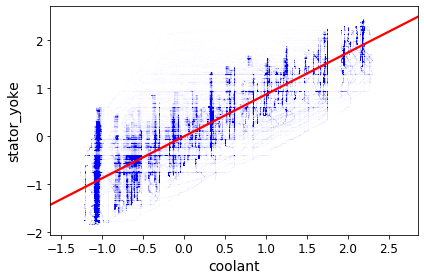

Response variable:   stator_yoke
Predictor variable:  u_d
Saving figure stator_yoke_vs_u_d


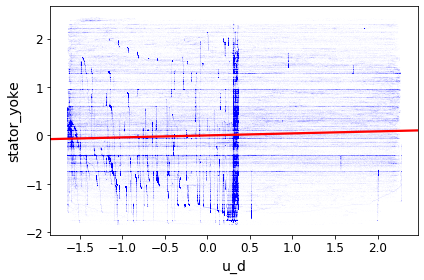

Response variable:   stator_yoke
Predictor variable:  u_q
Saving figure stator_yoke_vs_u_q


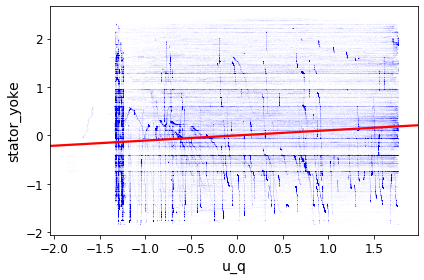

Response variable:   stator_yoke
Predictor variable:  motor_speed
Saving figure stator_yoke_vs_motor_speed


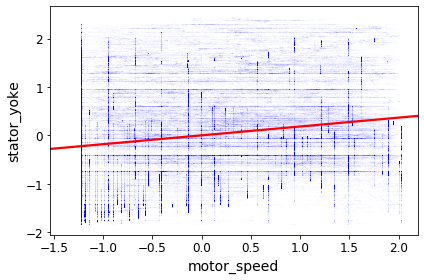

Response variable:   stator_yoke
Predictor variable:  i_d
Saving figure stator_yoke_vs_i_d


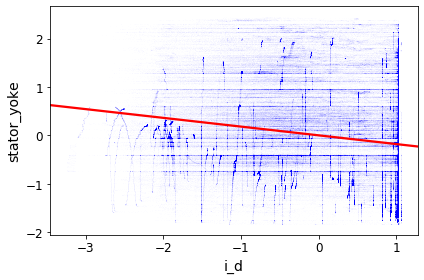

Response variable:   stator_yoke
Predictor variable:  i_q
Saving figure stator_yoke_vs_i_q


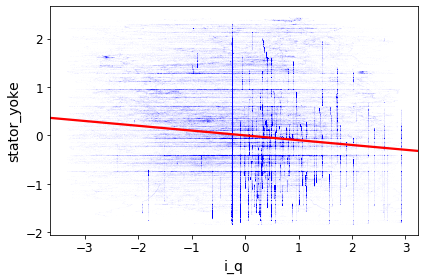

Response variable:   stator_tooth
Predictor variable:  ambient
Saving figure stator_tooth_vs_ambient


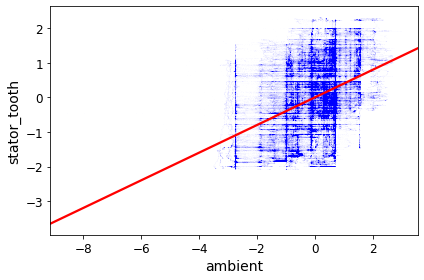

Response variable:   stator_tooth
Predictor variable:  coolant
Saving figure stator_tooth_vs_coolant


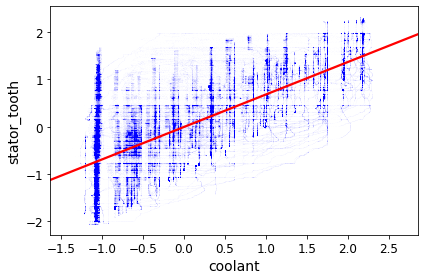

Response variable:   stator_tooth
Predictor variable:  u_d
Saving figure stator_tooth_vs_u_d


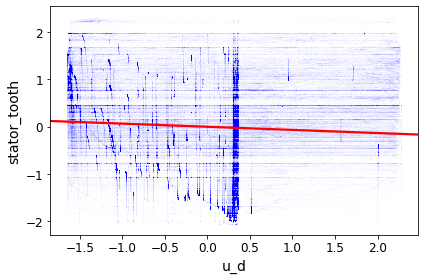

Response variable:   stator_tooth
Predictor variable:  u_q
Saving figure stator_tooth_vs_u_q


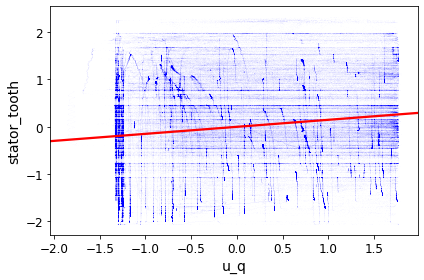

Response variable:   stator_tooth
Predictor variable:  motor_speed
Saving figure stator_tooth_vs_motor_speed


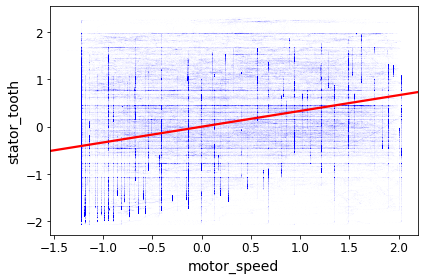

Response variable:   stator_tooth
Predictor variable:  i_d
Saving figure stator_tooth_vs_i_d


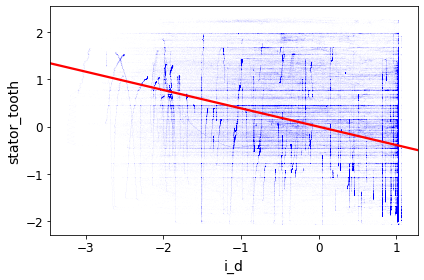

Response variable:   stator_tooth
Predictor variable:  i_q
Saving figure stator_tooth_vs_i_q


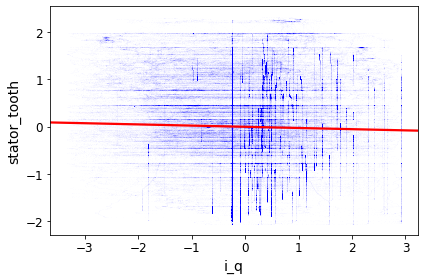

Response variable:   stator_winding
Predictor variable:  ambient
Saving figure stator_winding_vs_ambient


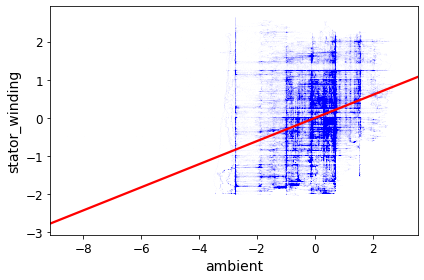

Response variable:   stator_winding
Predictor variable:  coolant
Saving figure stator_winding_vs_coolant


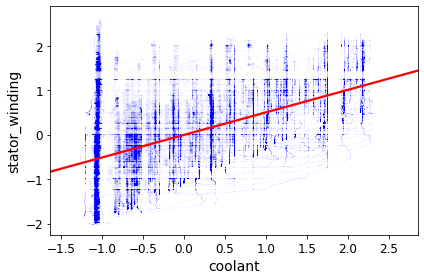

Response variable:   stator_winding
Predictor variable:  u_d
Saving figure stator_winding_vs_u_d


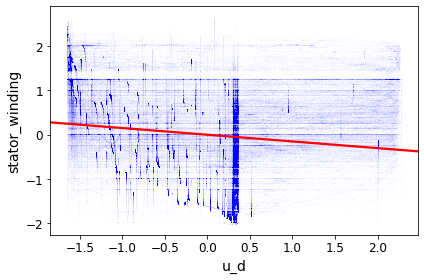

Response variable:   stator_winding
Predictor variable:  u_q
Saving figure stator_winding_vs_u_q


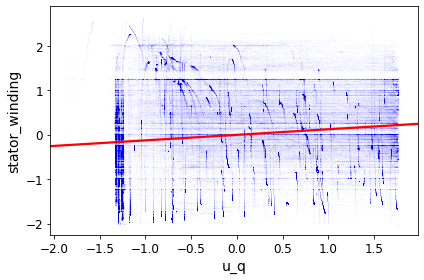

Response variable:   stator_winding
Predictor variable:  motor_speed
Saving figure stator_winding_vs_motor_speed


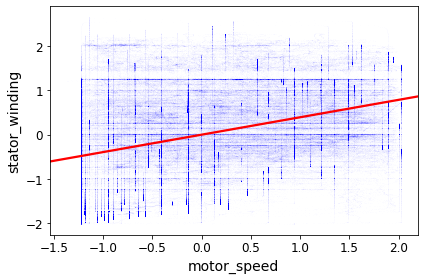

Response variable:   stator_winding
Predictor variable:  i_d
Saving figure stator_winding_vs_i_d


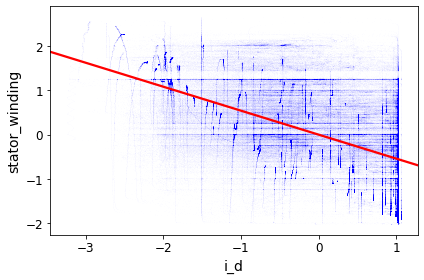

Response variable:   stator_winding
Predictor variable:  i_q
Saving figure stator_winding_vs_i_q


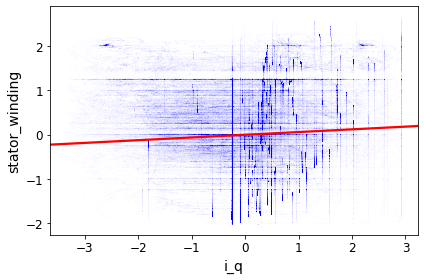

In [30]:
# Print simple linear regression plots of response variables against predictor variables.
# 5 models considered.
# Response variables:
# 'torque' Torque induced by current.
# 'pm' (Permanent Magnet surface temperature - representing the rotor temperature).
# 'stator_yoke' (Stator yoke temperature measured with a thermal sensor)
# 'stator_tooth' (Stator tooth temperature measured with a thermal sensor)
# 'stator_winding' (Stator winding temperature measured with a thermal sensor)   

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use the ALL data.
sample_motor_data = motor_data.sample(frac = FRAC)

# Where to save the simple regression plots.
IMAGE_Subfolder = "Simple regression plots"

for y_var in response_variables:
    for x_var in predictor_variables:
        print('Response variable:  ', y_var)
        print('Predictor variable: ', x_var)
        
        #sns.regplot(x=sample_motor_data.iloc[:,i], y=sample_motor_data['pm'], data=sample_motor_data,
        #             scatter_kws={"color": "black"}, line_kws={"color": "red"})
        sns.regplot(x=sample_motor_data[x_var], y=sample_motor_data[y_var], data=sample_motor_data,
                     scatter_kws={"color": "blue", "s":1, "alpha" : 0.002}, line_kws={"color": "red"})
        save_fig(IMAGE_Subfolder, y_var + '_vs_' + x_var)
        plt.show()
    

# Multiple Linear Regression.

Response variable:  torque
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Summary of multilinear model using ALL data: 
                            OLS Regression Results                            
Dep. Variable:                 torque   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 3.684e+07
Date:                Tue, 18 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:54:19   Log-Likelihood:             1.3597e+06
No. Observations:              998070   AIC:                        -2.719e+06
Df Residuals:                  998062   BIC:                        -2.719e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t     

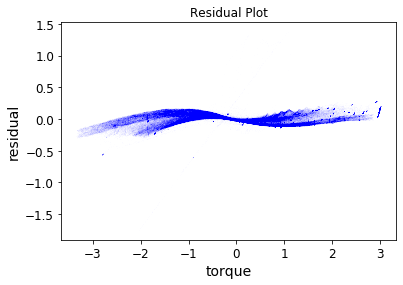

 
Summary of multilinear model using the TEST data: 
R2 score:  0.9961447836328445
Adjusted R2 score:  0.9961447565939285
RSE score:  0.061959606630553166
 
Response variable:  pm
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Summary of multilinear model using ALL data: 
                            OLS Regression Results                            
Dep. Variable:                     pm   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                 1.266e+05
Date:                Tue, 18 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:54:31   Log-Likelihood:            -1.0947e+06
No. Observations:              998070   AIC:                         2.189e+06
Df Residuals:                  998062   BIC:                         2.190e+06
Df Model:                           7                 

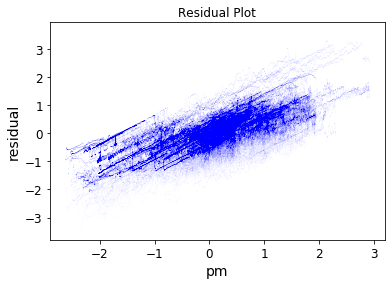

 
Summary of multilinear model using the TEST data: 
R2 score:  0.47033232981683776
Adjusted R2 score:  0.47032861494372236
RSE score:  0.7246382631350616
 
Response variable:  stator_yoke
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Summary of multilinear model using ALL data: 
                            OLS Regression Results                            
Dep. Variable:            stator_yoke   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                 7.909e+05
Date:                Tue, 18 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:54:42   Log-Likelihood:            -4.7955e+05
No. Observations:              998070   AIC:                         9.591e+05
Df Residuals:                  998062   BIC:                         9.592e+05
Df Model:                           7        

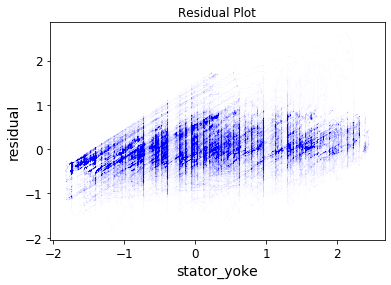

 
Summary of multilinear model using the TEST data: 
R2 score:  0.8472537699537624
Adjusted R2 score:  0.8472526986539731
RSE score:  0.3912355506732365
 
Response variable:  stator_tooth
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Summary of multilinear model using ALL data: 
                            OLS Regression Results                            
Dep. Variable:           stator_tooth   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                 3.376e+05
Date:                Tue, 18 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:54:54   Log-Likelihood:            -8.0985e+05
No. Observations:              998070   AIC:                         1.620e+06
Df Residuals:                  998062   BIC:                         1.620e+06
Df Model:                           7         

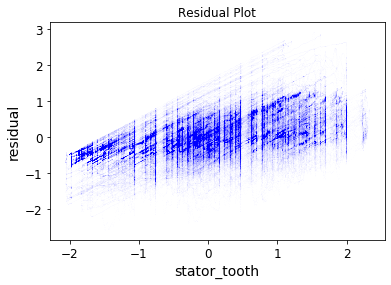

 
Summary of multilinear model using the TEST data: 
R2 score:  0.7030560181227603
Adjusted R2 score:  0.703053935478723
RSE score:  0.5447033490654154
 
Response variable:  stator_winding
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Summary of multilinear model using ALL data: 
                            OLS Regression Results                            
Dep. Variable:         stator_winding   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                 2.420e+05
Date:                Tue, 18 Aug 2020   Prob (F-statistic):               0.00
Time:                        19:55:06   Log-Likelihood:            -9.1935e+05
No. Observations:              998070   AIC:                         1.839e+06
Df Residuals:                  998062   BIC:                         1.839e+06
Df Model:                           7        

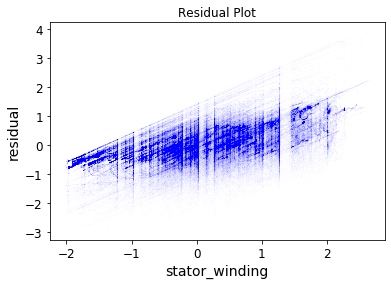

 
Summary of multilinear model using the TEST data: 
R2 score:  0.629266220739515
Adjusted R2 score:  0.6292636205639198
RSE score:  0.6078669212983207
 


In [31]:
# Multiple linear regression. (Using statsmodels.api).
# 5 models considered.
# Response variables:
# 'torque' Torque induced by current
# 'pm' (Permanent Magnet surface temperature - representing the rotor temperature).
# 'stator_yoke' (Stator yoke temperature measured with a thermal sensor)
# 'stator_tooth' (Stator tooth temperature measured with a thermal sensor)
# 'stator_winding' (Stator winding temperature measured with a thermal sensor)

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import f
import statsmodels.api as sm # Loaded in order to calculate the starndard error of the estimators (coefficients).
from sklearn.model_selection import KFold # Used for K fold cross validation.
from statistics import mean, variance, stdev 

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use the ALL data.
sample_motor_data = motor_data.sample(frac = FRAC)

kf = KFold(n_splits=5, shuffle=True, random_state=1)

response_variables = ['torque','pm','stator_yoke','stator_tooth','stator_winding']

rows, cols  =  sample_motor_data.shape

N = rows # The number of observations.
p = len(predictor_variables) # The number of predictor variables.

X = sample_motor_data[predictor_variables]
#X = X.to_numpy()
# Create design matrix X.
X = sm.add_constant(X) # Add a column of 1s.

for y_var in response_variables:
    
    print('Response variable: ', y_var)
    print('Predictor variables: ')
    print(predictor_variables) # Print out the predictor variables.
    
    y = sample_motor_data[y_var]
    #print(y)
   
    # Fit a multilinear model and display the results for ALL the data.
    print('Summary of multilinear model using ALL data: ')
    lm=sm.OLS(y, X)
    model=lm.fit()
    print(model.summary())  
    print(' ')
    
    # Produce a residual plot using ALL the data.
    y_pred = model.predict(X)
    resid = y-y_pred
    colors = 'b'
    area = 1
    plt.scatter(x=y, y=resid, s=area, c=colors, alpha=0.002)
    plt.title('Residual Plot')
    plt.xlabel(y_var)
    plt.ylabel('residual')
    plt.show()
    print(' ')
    
       
    R2_scores = []
    adjusted_R2_scores = []
    rse_scores = []
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index) 

        #X_train, X_test = X[train_index], X[test_index]
        #y_train, y_test = y[train_index], y[test_index]
        
        X_train, X_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
        y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]
    
        lm=sm.OLS(y_train, X_train)

        # Fit a multilinear model using the training data.
        model=lm.fit()
        #print(model.summary())
        
        # Predict the response for the test data.
        y_pred = model.predict(X_test)
        
        # Calculate metrics on the test data.
        # The coefficient of determination: 1 is perfect prediction. Use test data.
        R2_score = r2_score(y_test, y_pred)
        R2_scores.append(R2_score)
        
        adjusted_R2_score = 1 - (1-R2_score)*(N-1)/(N-p-1)
        adjusted_R2_scores.append(adjusted_R2_score)        
        
        # The residual standard error = estimate of the standard deviation of the residuals.
        mse = mean_squared_error(y_test, y_pred)
        rse_score = math.sqrt(mse)
        rse_scores.append(rse_score)
        
    print('Summary of multilinear model using the TEST data: ')
    mean_R2_score = mean(R2_scores)
    print('R2 score: ', mean_R2_score)
    
    mean_adjusted_R2_score = mean(adjusted_R2_scores)        
    print('Adjusted R2 score: ', mean_adjusted_R2_score)  
    
    mean_rse_score = mean(rse_scores)
    print('RSE score: ', mean_rse_score)
    print(' ')
 

USING ALL DATA:-
Note there are 5 linear models being considered. 
The response variables being; 'torque','pm','stator_yoke','stator_tooth' and 'stator_winding' respectively.
Null Hypothesis: All coefficients of the model are zero.
Since p_value = 0 given the F statistic value, this means that the Null Hypothesis can be rejected in all 5 models.
The p values imply that NOT ALL of the coefficients of the linear model are zero.


Response variable: 'torque'.
All p values associated with t statistics of the predictor variables are zero, suggesting that all
predictor variables are related to 'torque'.

Response variable: 'pm'.
All p values associated with t statistics of the predictor variables are zero, suggesting that all
predictor variables are related to 'pm'.

Response variable: 'stator_yoke'.
All p values associated with t statistics of the predictor variables are zero, suggesting that all
predictor variables are related to 'stator_yoke'.

Response variable: 'stator_tooth'.
All p values associated with t statistics of the predictor variables are zero, suggesting that all
predictor variables are related to 'stator_tooth'.

Response variable: 'stator_winding'.
The p values associated with the t statistic of the predictor variable 'i_q' is 0.299, suggesting that
that 'stator_winding' is not related to 'i_q'.
The p values associated with t statistics of all the other the predictor variables are zero, suggesting that
'stator_winding' is related to these predictor variables.



USING TEST DATA:-

Response variable: 'torque'.
R2 score: 0.996 
Excellent fit.
'torque' has a strong linear relationship to 'i_q'


Response variable: 'pm'.
R2 score: 0.470
Fair fit.
'pm' is influenced by all variables, but less so by 'i_d' and 'i_q'.


Response variable: 'stator_yoke'.
R2 score: 0.847
Very good fit.
'stator_yoke' is strongly related to 'coolant' and 'i_d'.


Response variable: 'stator_tooth'.
R2 score: 0.703
Reasonable fit.
'stator_tooth' is quite strongly related to 'coolant' and 'i_d'.


Response variable: 'stator_winding'.
R2 score: 0.629
Reasonable fit.
'stator_winding' is quite strongly related to 'coolant' and 'i_d'.



# Variance Inflation Factor.

In [32]:
# Calculate the variance inflation factor (VIF) for the predictor variables.

# Import libraries.
import pandas as pd
import numpy as np
from patsy import dmatrix
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use the ALL data.
sample_motor_data = motor_data.sample(frac = FRAC)

print('Predictor variables: ')
print(predictor_variables) # Print out the predictor variables.

features = "+".join(predictor_variables)

# Create the design matrix X dataframe.
X = dmatrix(features, sample_motor_data, return_type='dataframe')

# For each X, calculate VIF and save in dataframe.
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Features"] = X.columns
print(' ')
print(vif.round(3))
print(' ')
print(' ')



Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
 
      VIF     Features
0   1.000    Intercept
1   1.302      ambient
2   1.256      coolant
3   3.644          u_d
4   4.804          u_q
5  10.588  motor_speed
6   4.899          i_d
7   3.726          i_q
 
 


# The VIF values are generally okay!

# Create a dataframe of best estimators (models), and their results.

In [13]:
# Need a dataframe to hold the best estimators (models), and their test results
# for each of the response variables.

names = response_variables
ml_algs = ['MultilinearReg','LinearSVReg', 'RandomforestReg', 'ExtraReg', 'AdaBoostReg', 'KnnReg', 'EnsembleReg']

estimators_df = pd.DataFrame(index = names, columns = ml_algs)

#print(estimators_df)


In [14]:
# Populate the estimators data frame.
# rows indexed by 'response variable names'.
# columns indexed by 'ML algorithm names'.
# Each element holds a list of [best_estimator, cv_metrics].
# cv_metrics is a list comprising of [r2_score, adjusted_r2_score, rmse].

def populate_estimators_df(best_est_dict, cv_metrics_dict, ml_algorithm):
        for y_var in response_variables:
            best_est = best_est_dict[y_var]
            cv_metrics = cv_metrics_dict[y_var]
            estimator_data = [best_est, cv_metrics]
            estimators_df.loc[y_var, ml_algorithm] = estimator_data
    

# Cross validation and metrics generation.

In [15]:
# General model fit and metrics generation.
# Cross validation used to produce the metrics.

# 5 models considered.
# Response variables:
# 'torque' Torque induced by current
# 'pm' (Permanent Magnet surface temperature - representing the rotor temperature).
# 'stator_yoke' (Stator yoke temperature measured with a thermal sensor)
# 'stator_tooth' (Stator tooth temperature measured with a thermal sensor)
# 'stator_winding' (Stator winding temperature measured with a thermal sensor)

from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import f
import statsmodels.api as sm # Loaded in order to calculate the starndard error of the estimators (coefficients).
from sklearn.model_selection import KFold # Used for K fold cross validation.
from statistics import mean, variance, stdev 

kf = KFold(n_splits=5, shuffle=True, random_state=1)


def cross_validation_metrics(data, best_est_dict):

    rows, cols  =  data.shape

    N = rows # The number of observations.
    p = len(predictor_variables) # The number of predictor variables.

    #X = motor_data[predictor_variables]
    X = data[predictor_variables]
    #X = X.to_numpy()   

    cv_metrics_all = []
    for y_var in response_variables:

        print('Response variable: ', y_var)
        print('Predictor variables: ')
        print(predictor_variables) # Print out the predictor variables.
        print('Best estimator: ') # Print out the best estimator (model)
        print(best_est_dict[y_var])
        print(' ')
        
        #y = motor_data[y_var]
        y = data[y_var]
        #print(y)
        
        model = best_est_dict[y_var]
        # Fit model using all the data.
        model.fit(X, y)
        # Predict the response using ALL the data.
        y_pred = model.predict(X)

        print('Summary of the model using ALL data: ')
        R2 = r2_score(y, y_pred)
        print('Coefficient of determination (R2 score):              ', R2)    
        adjusted_R2 = 1 - (1-R2)*(N-1)/(N-p-1)
        print('Adjusted coefficient of determination (Adj R2 score): ', adjusted_R2) 
        # The mean squared error
        mse = mean_squared_error(y, y_pred)
        rmse = math.sqrt(mse)
        #print('Mean squared error: %.4f' % mse) 
        print('Root mean squared error (RSE score):                  ', rmse) 

        # Produce a residual plot using ALL the data.    
        resid = y-y_pred
        colors = 'b'
        area = 1
        plt.scatter(x=y, y=resid, s=area, c=colors, alpha=0.002)
        plt.title('Residual Plot')
        plt.xlabel(y_var)
        plt.ylabel('residual')
        plt.show()
        print(' ')


        R2_scores = []
        adjusted_R2_scores = []
        rse_scores = []

        for train_index, test_index in kf.split(X):
            #print("TRAIN:", train_index, "TEST:", test_index) 

            #X_train, X_test = X[train_index], X[test_index]
            #y_train, y_test = y[train_index], y[test_index]
           
            X_train, X_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
            y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

            # Fit the model using the training data.
            model.fit(X_train, y_train)

            # Predict the response for the test data.
            y_pred = model.predict(X_test)

            # Calculate metrics on the test data.
            # The coefficient of determination: 1 is perfect prediction. Use test data.
            R2_score = r2_score(y_test, y_pred)
            R2_scores.append(R2_score)
            
            adjusted_R2_score = 1 - (1-R2_score)*(N-1)/(N-p-1)
            adjusted_R2_scores.append(adjusted_R2_score)
            
            # The residual standard error = estimate of the standard deviation of the residuals.
            mse = mean_squared_error(y_test, y_pred)
            rse_score = math.sqrt(mse)
            rse_scores.append(rse_score)

        print('Summary of the model using the TEST data: ')
        mean_R2_score = mean(R2_scores)
        print('R2 score:          ', mean_R2_score)

        mean_adjusted_R2_score = mean(adjusted_R2_scores)        
        print('Adjusted R2 score: ', mean_adjusted_R2_score)         
        
        mean_rse_score = mean(rse_scores)        
        print('RSE score:         ', mean_rse_score)
        print(' ')
        
        
        cv_metrics = [mean_R2_score, mean_adjusted_R2_score, mean_rse_score]
        cv_metrics_all.append(cv_metrics)
        
    cv_metrics_dict = dict(zip(response_variables, cv_metrics_all))    
    return(cv_metrics_dict)


# Grid search with Cross Validation.

In [16]:

# Grid search with Cross Validation.
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def det_hyper_params_gridCV(X, y, model, params):
    grid_search = GridSearchCV(estimator = model, param_grid = params, cv=5,scoring='r2', return_train_score=True)
    grid_search.fit(X, y)
    #print('grid_search.best_params_', grid_search.best_params_)
    #print('grid_search.best_score_', grid_search.best_score_)
    #print('grid_search.best_estimator', grid_search.best_estimator_)
    return(grid_search)
    

# Randomised search with Cross Validation.

In [17]:
# Randomised search with Cross Validation.
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

def det_hyper_params_randCV(X, y, model, params):
    n_iters = 3 # May need to change this value.
    rand_search = RandomizedSearchCV(estimator = model, param_distributions = params,n_iter= n_iters, cv=5,scoring='r2', return_train_score=True)
    rand_search.fit(X, y)
    #print('rand_search.best_params_', rand_search.best_params_)
    #print('rand_search.best_score_', rand_search.best_score_)
    #print('rand_search.best_estimator', rand_search.best_estimator_)
    return(rand_search)

# Function to go through the list of response variables.

In [18]:
def multiple_response_vars(data, model, params, search_type):
    best_estimators = []
    for y_var in response_variables:
        #print('Response variable:')
        #print(y_var)
        #print('Predictor variables:')
        #print(predictor_variables)
        y = data[y_var]
        X = data[predictor_variables]
        if search_type == 'GridSearchCV':
            search = det_hyper_params_gridCV(X, y, model, params)
        elif search_type == 'RandomizedSearchCV':
            search = det_hyper_params_randCV(X, y, model, params)
        else :
            print('Unknown search method.')
        
        best_est = search.best_estimator_
        # print(best_est.score(X,y)) Returns R2 score.
        y_pred = best_est.predict(X)
        r2 = r2_score(y,y_pred)
        #print('R2  :', r2)
        mse = mean_squared_error(y,y_pred)
        #print('MSE :', mse)
        #print(' ')
        best_estimators.append(best_est)
    return(best_estimators)

# Multiple Linear Regression Model.

Tuning time :  0:00:09.060184
 
Response variable:  torque
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
LinearRegression()
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9961449115110849
Adjusted coefficient of determination (Adj R2 score):  0.9961448844730657
Root mean squared error (RSE score):                   0.06195934779089215


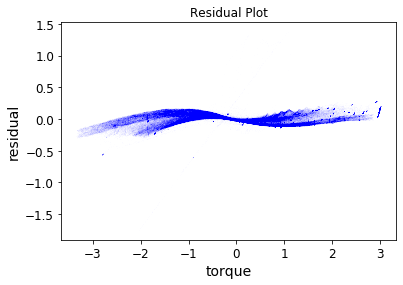

 
Summary of the model using the TEST data: 
R2 score:           0.9961448681201854
Adjusted R2 score:  0.9961448410818621
RSE score:          0.061959189070001475
 
Response variable:  pm
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
LinearRegression()
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.4703495531366614
Adjusted coefficient of determination (Adj R2 score):  0.4703458383843434
Root mean squared error (RSE score):                   0.7246310897142293


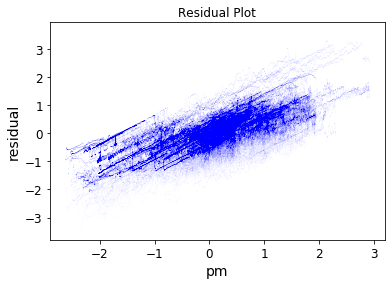

 
Summary of the model using the TEST data: 
R2 score:           0.4703275690238836
Adjusted R2 score:  0.4703238541173779
RSE score:          0.7246407457661496
 
Response variable:  stator_yoke
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
LinearRegression()
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.8472589613624819
Adjusted coefficient of determination (Adj R2 score):  0.847257890099103
Root mean squared error (RSE score):                   0.39123081680568234


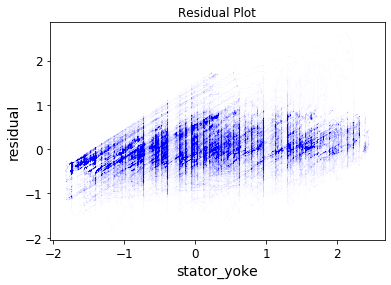

 
Summary of the model using the TEST data: 
R2 score:           0.847252247619824
Adjusted R2 score:  0.8472511763093578
RSE score:          0.39123505044935925
 
Response variable:  stator_tooth
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
LinearRegression()
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.7030667209049715
Adjusted coefficient of determination (Adj R2 score):  0.7030646383359991
Root mean squared error (RSE score):                   0.5446962371770335


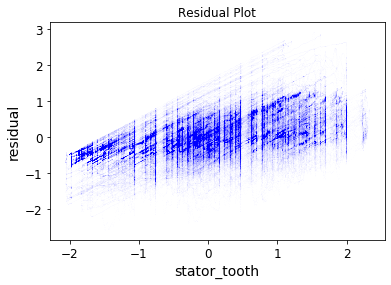

 
Summary of the model using the TEST data: 
R2 score:           0.7030540713745304
Adjusted R2 score:  0.7030519887168393
RSE score:          0.5447021062343387
 
Response variable:  stator_winding
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
LinearRegression()
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.629279756101583
Adjusted coefficient of determination (Adj R2 score):  0.6292771560209194
Root mean squared error (RSE score):                   0.6078586345221474


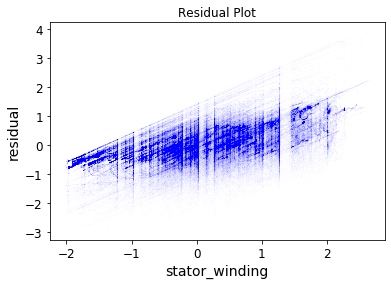

 
Summary of the model using the TEST data: 
R2 score:           0.6292660205283127
Adjusted R2 score:  0.6292634203513134
RSE score:          0.6078644177274094
 
Best model CV time :  0:00:44.764260


In [19]:
# Fine Tuning of hyperparameters.
# Multiple linear regression model.
# Grid search with cross validation.

import time, datetime
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use ALL the data.
sample_motor_data = motor_data.sample(frac = FRAC)

lin_reg = linear_model.LinearRegression()
params = {'fit_intercept' : [True]} # One choice! 

tic = time.perf_counter()
best_estimators = multiple_response_vars(sample_motor_data, lin_reg, params, 'GridSearchCV')
toc = time.perf_counter()
print('Tuning time : ', str(datetime.timedelta(seconds = toc-tic)))
print(' ')

# Use cross validation using the best estimators.
tic = time.perf_counter()
best_est_dict = dict(zip(response_variables, best_estimators))

cv_metrics_dict = cross_validation_metrics(sample_motor_data, best_est_dict)
#print (cv_metrics_dict)

toc = time.perf_counter()
print('Best model CV time : ', str(datetime.timedelta(seconds = toc-tic)))

populate_estimators_df(best_est_dict, cv_metrics_dict, 'MultilinearReg' )
#print(estimators_df)




In [40]:
MODEL_Subfolder = 'MultilinearReg'
save_all_models_and_results(best_est_dict, cv_metrics_dict, MODEL_Subfolder)

Saving model torque+MultilinearReg
Saving results torque+results
Saving model pm+MultilinearReg
Saving results pm+results
Saving model stator_yoke+MultilinearReg
Saving results stator_yoke+results
Saving model stator_tooth+MultilinearReg
Saving results stator_tooth+results
Saving model stator_winding+MultilinearReg
Saving results stator_winding+results


In [41]:
# Load in the saved estimators and cv metrics.
# Just need to supply the name of the subfolder.

#MODEL_Subfolder = 'MultilinearReg'
#best_estimators, cv_metrics_all = load_all_models_and_results(MODEL_Subfolder)
#print(best_estimators)
#print(cv_metrics_all)

In [2]:
# Fine Tuning of hyperparameters.
# Multiple linear regression model.
# Random search with cross validation.

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use ALL the data.
sample_motor_data = motor_data.sample(frac = FRAC)

lin_reg = linear_model.LinearRegression()
params = {'fit_intercept' : [True]} # One choice!

best_estimators = multiple_response_vars(sample_motor_data, lin_reg, params, 'RandomizedSearchCV')

# Use cross validation using the best estimators.
best_est_dict = dict(zip(response_variables, best_estimators))

cv_metrics_dict = cross_validation_metrics(sample_motor_data, best_est_dict)
#print (cv_metrics_dict)
populate_estimators_df(best_est_dict, cv_metrics_dict, 'MultilinearReg' )
#print(estimators_df)




In [1]:
#MODEL_Subfolder = 'MultilinearReg'
#save_all_models_and_results(best_est_dict, cv_metrics_dict, MODEL_Subfolder)

In [44]:
# Load in the saved estimators and cv metrics.
# Just need to supply the name of the subfolder.

#MODEL_Subfolder = 'MultilinearReg'
#best_estimators, cv_metrics_all = load_all_models_and_results(MODEL_Subfolder)
#print(best_estimators)
#print(cv_metrics_all)

#  Support Vector Machine Model.

Tuning time :  0:02:25.625694
 
Response variable:  torque
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
LinearSVR(C=100.0, dual=False, loss='squared_epsilon_insensitive',
          random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9961449112324152
Adjusted coefficient of determination (Adj R2 score):  0.9961448841943942
Root mean squared error (RSE score):                   0.061959350030294486


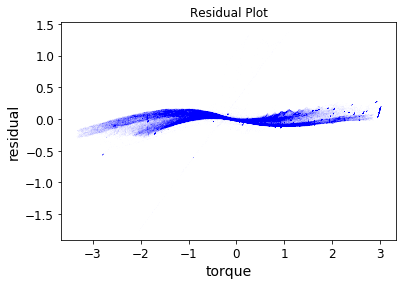

 
Summary of the model using the TEST data: 
R2 score:           0.996144681228974
Adjusted R2 score:  0.9961446541893398
RSE score:          0.0619597290996837
 
Response variable:  pm
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
LinearSVR(C=0.1, dual=False, loss='squared_epsilon_insensitive', random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.47034955254237343
Adjusted coefficient of determination (Adj R2 score):  0.47034583779005124
Root mean squared error (RSE score):                   0.7246310901207613


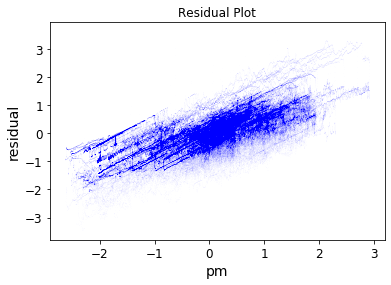

 
Summary of the model using the TEST data: 
R2 score:           0.4703380853820223
Adjusted R2 score:  0.47033437054927413
RSE score:          0.724635718180808
 
Response variable:  stator_yoke
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
LinearSVR(C=0.1, dual=False, loss='squared_epsilon_insensitive', random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.8472589611533132
Adjusted coefficient of determination (Adj R2 score):  0.8472578898899329
Root mean squared error (RSE score):                   0.3912308170735647


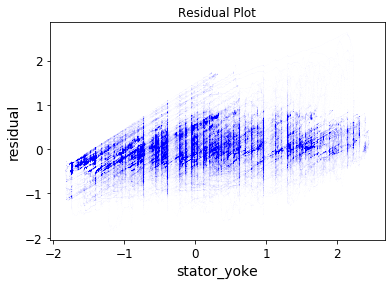

 
Summary of the model using the TEST data: 
R2 score:           0.8472547604217741
Adjusted R2 score:  0.8472536891289315
RSE score:          0.3912338402432618
 
Response variable:  stator_tooth
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
LinearSVR(C=0.1, dual=False, loss='squared_epsilon_insensitive', random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.7030667204403191
Adjusted coefficient of determination (Adj R2 score):  0.7030646378713435
Root mean squared error (RSE score):                   0.544696237603214


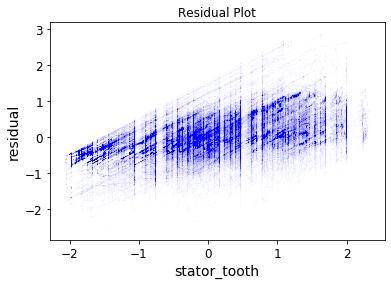

 
Summary of the model using the TEST data: 
R2 score:           0.7030583266386978
Adjusted R2 score:  0.7030562440108515
RSE score:          0.5447007349522531
 
Response variable:  stator_winding
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
LinearSVR(C=0.1, dual=False, loss='squared_epsilon_insensitive', random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.6292797558548949
Adjusted coefficient of determination (Adj R2 score):  0.6292771557742296
Root mean squared error (RSE score):                   0.6078586347243907


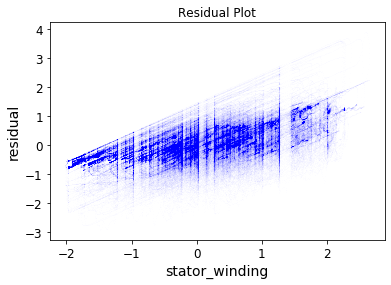

 
Summary of the model using the TEST data: 
R2 score:           0.6292682850143059
Adjusted R2 score:  0.6292656848531888
RSE score:          0.6078639724727509
 
Best model CV time :  0:01:22.095080


In [45]:
# Fine Tuning of hyperparameters.
# Support vector machine regression model.
# Grid search with cross validation.

import time, datetime
from sklearn.svm import LinearSVR

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use ALL the data.
sample_motor_data = motor_data.sample(frac = FRAC)

svm_reg = LinearSVR(random_state = 1, dual = False, loss = 'squared_epsilon_insensitive') 

params = { 'C' : [0.01, 0.1, 1.0, 10.0, 100.0]} 

tic = time.perf_counter()
best_estimators = multiple_response_vars(sample_motor_data, svm_reg, params, 'GridSearchCV')
toc = time.perf_counter()
print('Tuning time : ', str(datetime.timedelta(seconds = toc-tic)))
print(' ')

# Use cross validation using the best estimators.
tic = time.perf_counter()
best_est_dict = dict(zip(response_variables, best_estimators))

cv_metrics_dict = cross_validation_metrics(sample_motor_data, best_est_dict)
#print (cv_metrics_dict)

toc = time.perf_counter()
print('Best model CV time : ', str(datetime.timedelta(seconds = toc-tic)))

populate_estimators_df(best_est_dict, cv_metrics_dict, 'LinearSVReg' )
#print(estimators_df)




In [46]:
MODEL_Subfolder = 'LinearSVReg'
save_all_models_and_results(best_est_dict, cv_metrics_dict, MODEL_Subfolder)

Saving model torque+LinearSVReg
Saving results torque+results
Saving model pm+LinearSVReg
Saving results pm+results
Saving model stator_yoke+LinearSVReg
Saving results stator_yoke+results
Saving model stator_tooth+LinearSVReg
Saving results stator_tooth+results
Saving model stator_winding+LinearSVReg
Saving results stator_winding+results


In [47]:
# Load in the saved estimators and cv metrics.
# Just need to supply the name of the subfolder.

#MODEL_Subfolder = 'LinearSVReg'
#best_estimators, cv_metrics_all = load_all_models_and_results(MODEL_Subfolder)
#print(best_estimators)
#print(cv_metrics_all)

Response variable:  torque
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
LinearSVR(C=2.8000000000000003, dual=False, loss='squared_epsilon_insensitive',
          random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9961449112322353
Adjusted coefficient of determination (Adj R2 score):  0.9961448841942142
Root mean squared error (RSE score):                   0.061959350031740655


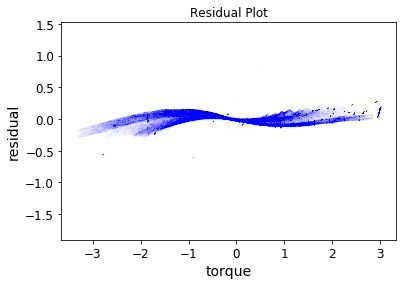

 
Summary of the model using the TEST data: 
R2 score:           0.9961448146705849
Adjusted R2 score:  0.9961447876318865
RSE score:          0.06195938937643169
 
Response variable:  pm
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
LinearSVR(C=0.78, dual=False, loss='squared_epsilon_insensitive',
          random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.47034955272740886
Adjusted coefficient of determination (Adj R2 score):  0.470345837975088
Root mean squared error (RSE score):                   0.7246310899941851


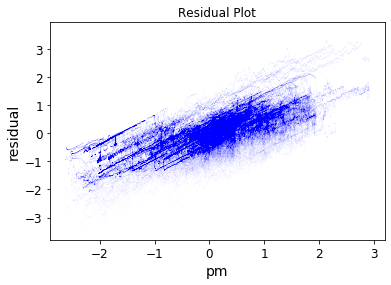

 
Summary of the model using the TEST data: 
R2 score:           0.4703350123317433
Adjusted R2 score:  0.470331297477442
RSE score:          0.7246385187985073
 
Response variable:  stator_yoke
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
LinearSVR(C=0.35, dual=False, loss='squared_epsilon_insensitive',
          random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.8472589612616575
Adjusted coefficient of determination (Adj R2 score):  0.8472578899982779
Root mean squared error (RSE score):                   0.39123081693480827


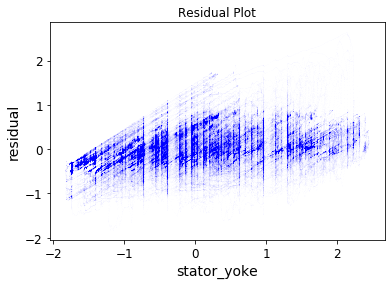

 
Summary of the model using the TEST data: 
R2 score:           0.847255404421699
Adjusted R2 score:  0.8472543331333733
RSE score:          0.3912335036379016
 
Response variable:  stator_tooth
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
LinearSVR(C=1.1900000000000002, dual=False, loss='squared_epsilon_insensitive',
          random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.7030667204723395
Adjusted coefficient of determination (Adj R2 score):  0.7030646379033642
Root mean squared error (RSE score):                   0.5446962375738448


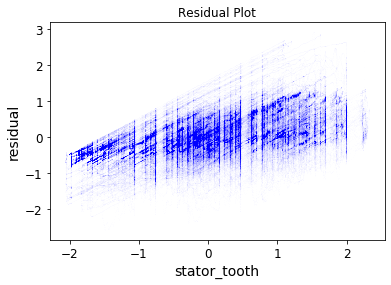

 
Summary of the model using the TEST data: 
R2 score:           0.7030587707560665
Adjusted R2 score:  0.7030566881313352
RSE score:          0.5447001997243595
 
Response variable:  stator_winding
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
LinearSVR(C=0.43000000000000005, dual=False, loss='squared_epsilon_insensitive',
          random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.6292797560393041
Adjusted coefficient of determination (Adj R2 score):  0.62927715595864
Root mean squared error (RSE score):                   0.6078586345732055


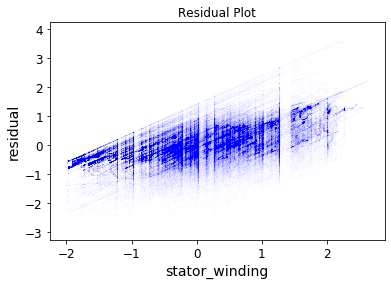

 
Summary of the model using the TEST data: 
R2 score:           0.6292690621361533
Adjusted R2 score:  0.6292664619804866
RSE score:          0.6078634051852052
 


{'torque': [0.9961448146705849, 0.9961447876318865, 0.06195938937643169],
 'pm': [0.4703350123317433, 0.470331297477442, 0.7246385187985073],
 'stator_yoke': [0.847255404421699, 0.8472543331333733, 0.3912335036379016],
 'stator_tooth': [0.7030587707560665, 0.7030566881313352, 0.5447001997243595],
 'stator_winding': [0.6292690621361533,
  0.6292664619804866,
  0.6078634051852052]}

In [48]:
# Fine Tuning of hyperparameters.
# Support vector machine regression model.
# Random search with cross validation.

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use ALL the data.
sample_motor_data = motor_data.sample(frac = FRAC)

svm_reg = LinearSVR(random_state = 1, dual = False, loss = 'squared_epsilon_insensitive') 
params = {'C' : np.linspace(0.1, 3.0, 291)} 

best_estimators = multiple_response_vars(sample_motor_data, svm_reg, params, 'RandomizedSearchCV')
best_est_dict = dict(zip(response_variables, best_estimators))
cross_validation_metrics(sample_motor_data, best_est_dict)

# It is clear that the tuning parameter C has very little effect on the results, and so using the default of C = 1.0 would suffice.

# Also, there is very little difference in the metric scores between the multilinear regression model, and the linear support vector regression model.

# Random Forest Regressor. Excellent test results.

Tuning time :  0:16:31.701039
 
Response variable:  torque
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
RandomForestRegressor(n_estimators=5, n_jobs=-1, random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.999983043106554
Adjusted coefficient of determination (Adj R2 score):  0.9999830429876252
Root mean squared error (RSE score):                   0.0041092523058361245


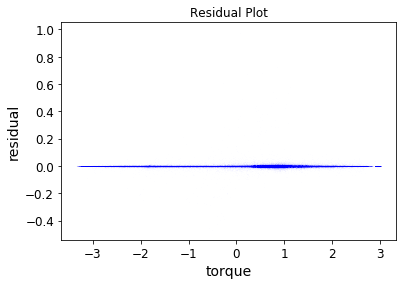

 
Summary of the model using the TEST data: 
R2 score:           0.999920014426516
Adjusted R2 score:  0.9999200138655298
RSE score:          0.008896518971487707
 
Response variable:  pm
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
RandomForestRegressor(n_estimators=5, n_jobs=-1, random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9962969270037776
Adjusted coefficient of determination (Adj R2 score):  0.9962969010319331
Root mean squared error (RSE score):                   0.0605903453932418


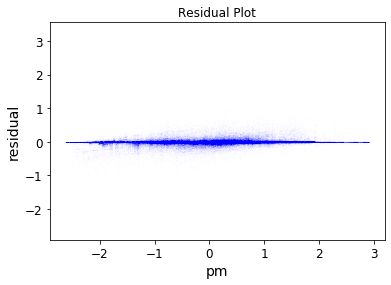

 
Summary of the model using the TEST data: 
R2 score:           0.9815040092184815
Adjusted R2 score:  0.9815038794951422
RSE score:          0.13541025291575143
 
Response variable:  stator_yoke
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
RandomForestRegressor(n_estimators=5, n_jobs=-1, random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9981087524812784
Adjusted coefficient of determination (Adj R2 score):  0.9981087392168393
Root mean squared error (RSE score):                   0.04353408012288701


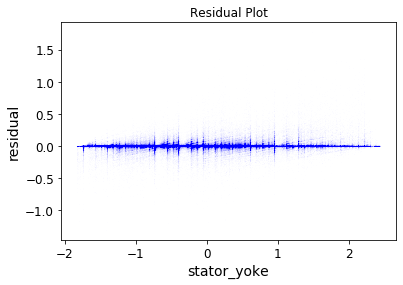

 
Summary of the model using the TEST data: 
R2 score:           0.9905321140008541
Adjusted R2 score:  0.9905320475969613
RSE score:          0.09740466297984979
 
Response variable:  stator_tooth
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
RandomForestRegressor(n_estimators=5, n_jobs=-1, random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9965973539631855
Adjusted coefficient of determination (Adj R2 score):  0.9965973300984133
Root mean squared error (RSE score):                   0.05830869542011089


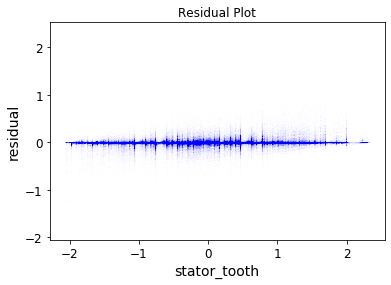

 
Summary of the model using the TEST data: 
R2 score:           0.9833863082826219
Adjusted R2 score:  0.9833861917609609
RSE score:          0.1288367988272243
 
Response variable:  stator_winding
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
RandomForestRegressor(n_estimators=5, n_jobs=-1, random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.995718096786689
Adjusted coefficient of determination (Adj R2 score):  0.9957180667551654
Root mean squared error (RSE score):                   0.06532777432034442


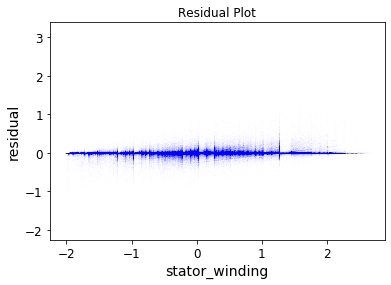

 
Summary of the model using the TEST data: 
R2 score:           0.979040669914448
Adjusted R2 score:  0.9790405229142511
RSE score:          0.14452639826448938
 
Best model CV time :  0:15:22.643191


In [49]:
import time, datetime
from sklearn.ensemble import RandomForestRegressor

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use ALL the data.
sample_motor_data = motor_data.sample(frac = FRAC)

params = { 'random_state' : [1],'n_estimators' : [5]} 
rand_reg = RandomForestRegressor( n_jobs=-1, bootstrap = True)

tic = time.perf_counter()
best_estimators = multiple_response_vars(sample_motor_data, rand_reg, params, 'GridSearchCV')
toc = time.perf_counter()
print('Tuning time : ', str(datetime.timedelta(seconds = toc-tic)))
print(' ')

# Use cross validation using the best estimators.
tic = time.perf_counter()
best_est_dict = dict(zip(response_variables, best_estimators))

cv_metrics_dict = cross_validation_metrics(sample_motor_data, best_est_dict)
#print (cv_metrics_dict)

toc = time.perf_counter()
print('Best model CV time : ', str(datetime.timedelta(seconds = toc-tic)))

populate_estimators_df(best_est_dict, cv_metrics_dict, 'RandomforestReg' )
#print(estimators_df)

In [50]:
MODEL_Subfolder = 'RandomforestReg'
save_all_models_and_results(best_est_dict, cv_metrics_dict, MODEL_Subfolder)

Saving model torque+RandomforestReg
Saving results torque+results
Saving model pm+RandomforestReg
Saving results pm+results
Saving model stator_yoke+RandomforestReg
Saving results stator_yoke+results
Saving model stator_tooth+RandomforestReg
Saving results stator_tooth+results
Saving model stator_winding+RandomforestReg
Saving results stator_winding+results


In [51]:
# Load in the saved estimators and cv metrics.
# Just need to supply the name of the subfolder.

#MODEL_Subfolder = 'RandomforestReg'
#best_estimators, cv_metrics_all = load_all_models_and_results(MODEL_Subfolder)
#print(best_estimators)
#print(cv_metrics_all)

# Extremely Randomised Tree Regressor. (Much faster to train than regular random forest. ) Also excellent test results - almost as good as random forest.

Tuning time :  0:05:42.577677
 
Response variable:  torque
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
ExtraTreesRegressor(bootstrap=True, n_estimators=5, n_jobs=-1, random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.999989140900442
Adjusted coefficient of determination (Adj R2 score):  0.9999891408242807
Root mean squared error (RSE score):                   0.0032884146123602297


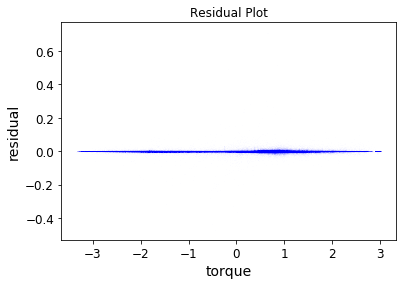

 
Summary of the model using the TEST data: 
R2 score:           0.9999490480453039
Adjusted R2 score:  0.9999490476879477
RSE score:          0.007103113115278329
 
Response variable:  pm
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
ExtraTreesRegressor(bootstrap=True, n_estimators=5, n_jobs=-1, random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9954493252946569
Adjusted coefficient of determination (Adj R2 score):  0.9954492933780796
Root mean squared error (RSE score):                   0.06716765522749057


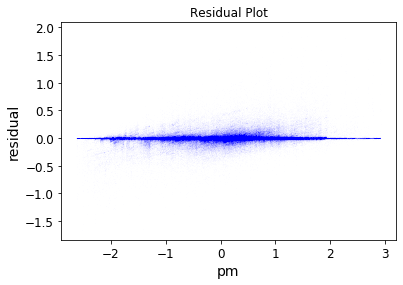

 
Summary of the model using the TEST data: 
R2 score:           0.980131029104163
Adjusted R2 score:  0.9801308897513009
RSE score:          0.1403409127784137
 
Response variable:  stator_yoke
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
ExtraTreesRegressor(bootstrap=True, n_estimators=5, n_jobs=-1, random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9976197763159477
Adjusted coefficient of determination (Adj R2 score):  0.9976197596220291
Root mean squared error (RSE score):                   0.04883869746561183


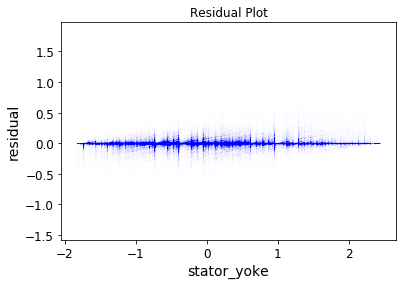

 
Summary of the model using the TEST data: 
R2 score:           0.9889002098663807
Adjusted R2 score:  0.9889001320169777
RSE score:          0.1054575171210794
 
Response variable:  stator_tooth
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
ExtraTreesRegressor(bootstrap=True, n_estimators=5, n_jobs=-1, random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9958131516521721
Adjusted coefficient of determination (Adj R2 score):  0.9958131222873245
Root mean squared error (RSE score):                   0.06467978286127844


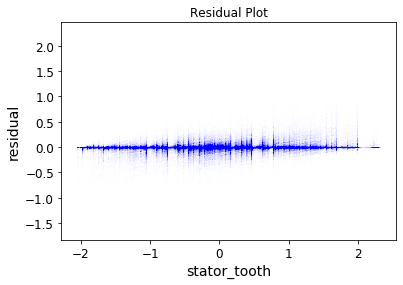

 
Summary of the model using the TEST data: 
R2 score:           0.9804151111534835
Adjusted R2 score:  0.980414973793057
RSE score:          0.13988310353181813
 
Response variable:  stator_winding
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
ExtraTreesRegressor(bootstrap=True, n_estimators=5, n_jobs=-1, random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9944136090152104
Adjusted coefficient of determination (Adj R2 score):  0.9944135698345413
Root mean squared error (RSE score):                   0.07461825751051933


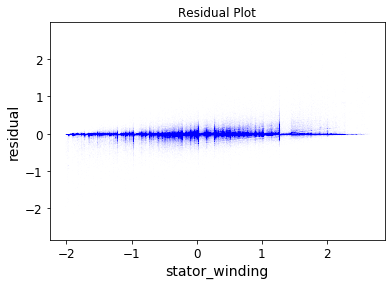

 
Summary of the model using the TEST data: 
R2 score:           0.9733747411712442
Adjusted R2 score:  0.9733745544325328
RSE score:          0.16289434836535208
 
Best model CV time :  0:04:53.411827


In [52]:
# Fine Tuning of hyperparameters.
# Random forest regression using extremely randomised trees.
# Grid search with cross validation.

import time, datetime
from sklearn.ensemble import ExtraTreesRegressor

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use ALL the data.
sample_motor_data = motor_data.sample(frac = FRAC)

params = { 'random_state' : [1],'n_estimators' : [5]} 
ex_tree_reg = ExtraTreesRegressor( n_jobs=-1, bootstrap = True)

tic = time.perf_counter()
best_estimators = multiple_response_vars(sample_motor_data, ex_tree_reg, params, 'GridSearchCV')
toc = time.perf_counter()
print('Tuning time : ', str(datetime.timedelta(seconds = toc-tic)))
print(' ')

# Use cross validation using the best estimators.
tic = time.perf_counter()
best_est_dict = dict(zip(response_variables, best_estimators))

cv_metrics_dict = cross_validation_metrics(sample_motor_data, best_est_dict)
#print (cv_metrics_dict)

toc = time.perf_counter()
print('Best model CV time : ', str(datetime.timedelta(seconds = toc-tic)))

populate_estimators_df(best_est_dict, cv_metrics_dict, 'ExtraReg' )
#print(estimators_df)



In [53]:
MODEL_Subfolder = 'ExtraReg'
save_all_models_and_results(best_est_dict, cv_metrics_dict, MODEL_Subfolder)


Saving model torque+ExtraReg
Saving results torque+results
Saving model pm+ExtraReg
Saving results pm+results
Saving model stator_yoke+ExtraReg
Saving results stator_yoke+results
Saving model stator_tooth+ExtraReg
Saving results stator_tooth+results
Saving model stator_winding+ExtraReg
Saving results stator_winding+results


In [54]:
# Load in the saved estimators and cv metrics.
# Just need to supply the name of the subfolder.

#MODEL_Subfolder = 'ExtraReg'
#best_estimators, cv_metrics_all = load_all_models_and_results(MODEL_Subfolder)
#print(best_estimators)
#print(cv_metrics_all)

# Adaptive Boosting Regressor. (AdaBoost).

Tuning time :  0:45:12.114337
 
Response variable:  torque
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=5,
                  random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9999983211183165
Adjusted coefficient of determination (Adj R2 score):  0.9999983211065415
Root mean squared error (RSE score):                   0.00129300352080866


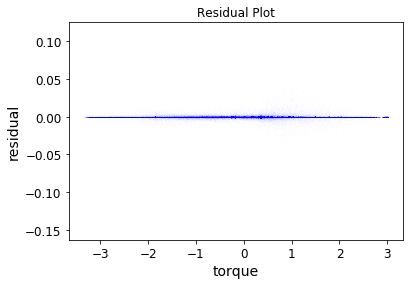

 
Summary of the model using the TEST data: 
R2 score:           0.999930092617611
Adjusted R2 score:  0.9999300921273091
RSE score:          0.008297379507679779
 
Response variable:  pm
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=5,
                  random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9998643053766622
Adjusted coefficient of determination (Adj R2 score):  0.9998643044249553
Root mean squared error (RSE score):                   0.01159854766411744


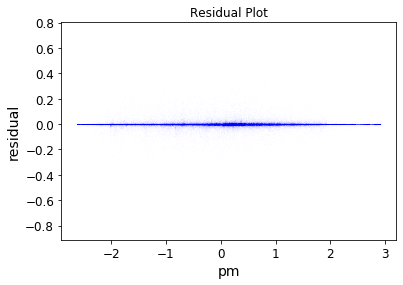

 
Summary of the model using the TEST data: 
R2 score:           0.9845582169752789
Adjusted R2 score:  0.9845581086729077
RSE score:          0.12372447191593272
 
Response variable:  stator_yoke
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=5,
                  random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9999392634404543
Adjusted coefficient of determination (Adj R2 score):  0.9999392630144728
Root mean squared error (RSE score):                   0.007801538936180855


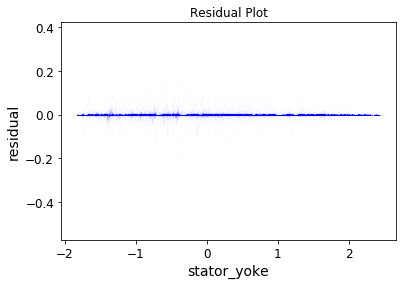

 
Summary of the model using the TEST data: 
R2 score:           0.9918572742629579
Adjusted R2 score:  0.991857217153199
RSE score:          0.09032017988902515
 
Response variable:  stator_tooth
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=5,
                  random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9999086458304457
Adjusted coefficient of determination (Adj R2 score):  0.9999086451897248
Root mean squared error (RSE score):                   0.009554085533229178


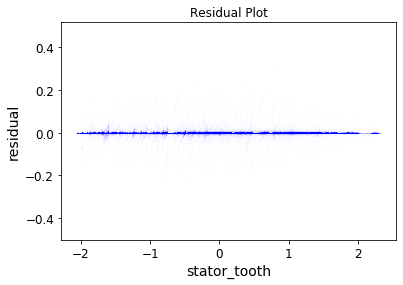

 
Summary of the model using the TEST data: 
R2 score:           0.9859941326380414
Adjusted R2 score:  0.9859940344065973
RSE score:          0.11828762630508795
 
Response variable:  stator_winding
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=5,
                  random_state=1)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9998623138717299
Adjusted coefficient of determination (Adj R2 score):  0.9998623129060554
Root mean squared error (RSE score):                   0.011714520937963806


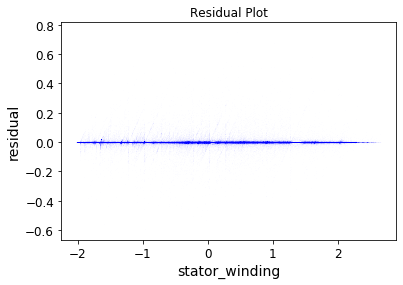

 
Summary of the model using the TEST data: 
R2 score:           0.981556221656091
Adjusted R2 score:  0.9815560922989485
RSE score:          0.13556729885283436
 
Best model CV time :  0:42:35.455313


In [55]:
# Fine Tuning of hyperparameters.
# Adaptive Boosting regression using decison trees.
# Grid search with cross validation.

import time, datetime
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use ALL the data.
sample_motor_data = motor_data.sample(frac = FRAC)

params = { 'random_state' : [1], 'n_estimators' : [5]} 
ada_reg = AdaBoostRegressor(DecisionTreeRegressor()) 

tic = time.perf_counter()
best_estimators = multiple_response_vars(sample_motor_data, ada_reg, params, 'GridSearchCV')
toc = time.perf_counter()
print('Tuning time : ', str(datetime.timedelta(seconds = toc-tic)))
print(' ')

# Use cross validation using the best estimators.
tic = time.perf_counter()
best_est_dict = dict(zip(response_variables, best_estimators))

cv_metrics_dict = cross_validation_metrics(sample_motor_data, best_est_dict)
#print (cv_metrics_dict)

toc = time.perf_counter()
print('Best model CV time : ', str(datetime.timedelta(seconds = toc-tic)))

populate_estimators_df(best_est_dict, cv_metrics_dict, 'AdaBoostReg' )
#print(estimators_df)



In [56]:
MODEL_Subfolder = 'AdaBoostReg'
save_all_models_and_results(best_est_dict, cv_metrics_dict, MODEL_Subfolder)

Saving model torque+AdaBoostReg
Saving results torque+results
Saving model pm+AdaBoostReg
Saving results pm+results
Saving model stator_yoke+AdaBoostReg
Saving results stator_yoke+results
Saving model stator_tooth+AdaBoostReg
Saving results stator_tooth+results
Saving model stator_winding+AdaBoostReg
Saving results stator_winding+results


In [57]:
# Load in the saved estimators and cv metrics.
# Just need to supply the name of the subfolder.

#MODEL_Subfolder = 'AdaBoostReg'
#best_estimators, cv_metrics_all = load_all_models_and_results(MODEL_Subfolder)
#print(best_estimators)
#print(cv_metrics_all)

# K Nearest Neighbours regression.

Tuning time :  1:17:08.020757
 
Response variable:  torque
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
KNeighborsRegressor(n_jobs=-1, n_neighbors=3)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9999091290447456
Adjusted coefficient of determination (Adj R2 score):  0.9999091284074137
Root mean squared error (RSE score):                   0.009512665128629144


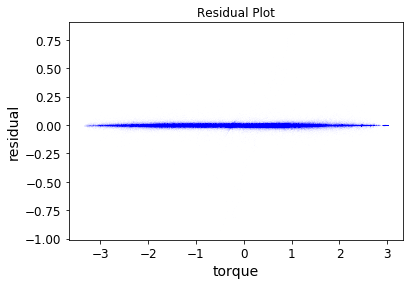

 
Summary of the model using the TEST data: 
R2 score:           0.9997858071555817
Adjusted R2 score:  0.9997858056533204
RSE score:          0.01459844468808425
 
Response variable:  pm
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
KNeighborsRegressor(n_jobs=-1, n_neighbors=2)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9899003519895306
Adjusted coefficient of determination (Adj R2 score):  0.9899002811547167
Root mean squared error (RSE score):                   0.10006343577358501


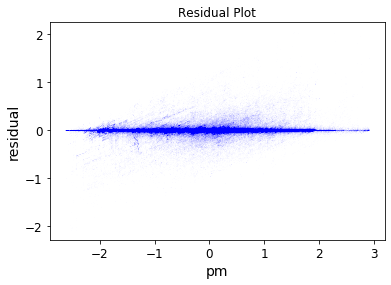

 
Summary of the model using the TEST data: 
R2 score:           0.9608879839545443
Adjusted R2 score:  0.9608877096388082
RSE score:          0.19691259734348363
 
Response variable:  stator_yoke
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
KNeighborsRegressor(n_jobs=-1, n_neighbors=2)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9951058148215925
Adjusted coefficient of determination (Adj R2 score):  0.9951057804957728
Root mean squared error (RSE score):                   0.0700318155368494


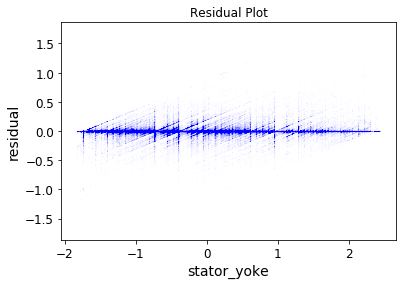

 
Summary of the model using the TEST data: 
R2 score:           0.9814195463453708
Adjusted R2 score:  0.9814194160296433
RSE score:          0.13644605184065223
 
Response variable:  stator_tooth
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
KNeighborsRegressor(n_jobs=-1, n_neighbors=2)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9909965095148053
Adjusted coefficient of determination (Adj R2 score):  0.9909964463679934
Root mean squared error (RSE score):                   0.09484848381700534


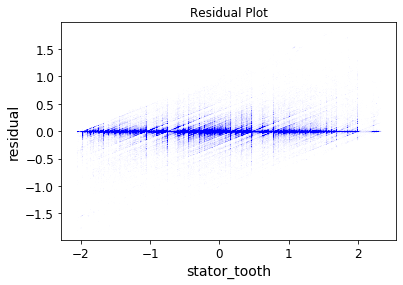

 
Summary of the model using the TEST data: 
R2 score:           0.9661524740667407
Adjusted R2 score:  0.966152236673992
RSE score:          0.18389714732855977
 
Response variable:  stator_winding
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
KNeighborsRegressor(n_jobs=-1, n_neighbors=2)
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.988236802979669
Adjusted coefficient of determination (Adj R2 score):  0.9882367204774004
Root mean squared error (RSE score):                   0.10827847352037676


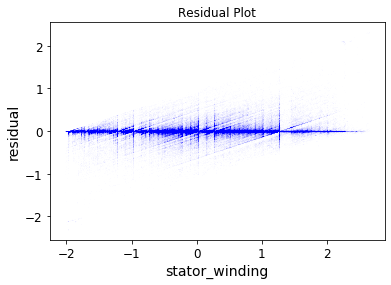

 
Summary of the model using the TEST data: 
R2 score:           0.956419585242512
Adjusted R2 score:  0.9564192795872488
RSE score:          0.20840878867389434
 
Best model CV time :  0:05:13.293892


In [58]:
# Fine Tuning of hyperparameters.
# K Nearest Neighbours regression.
# Grid search with cross validation.

import time, datetime
from sklearn.neighbors import KNeighborsRegressor
#from sklearn.ensemble import AdaBoostRegressor

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use ALL the data.
sample_motor_data = motor_data.sample(frac = FRAC)

params = {'n_neighbors' : np.arange(1,10,1)} 
knn_reg = KNeighborsRegressor(n_jobs = -1) 

tic = time.perf_counter()
best_estimators = multiple_response_vars(sample_motor_data, knn_reg, params, 'GridSearchCV')
toc = time.perf_counter()
print('Tuning time : ', str(datetime.timedelta(seconds = toc-tic)))
print(' ')

# Use cross validation using the best estimators.
tic = time.perf_counter()
best_est_dict = dict(zip(response_variables, best_estimators))
cv_metrics_dict = cross_validation_metrics(sample_motor_data, best_est_dict)
#print (cv_metrics_dict)
toc = time.perf_counter()
print('Best model CV time : ', str(datetime.timedelta(seconds = toc-tic)))


populate_estimators_df(best_est_dict, cv_metrics_dict, 'KnnReg' )
#print(estimators_df)





In [59]:
MODEL_Subfolder = 'KnnReg'
save_all_models_and_results(best_est_dict, cv_metrics_dict, MODEL_Subfolder)

Saving model torque+KnnReg
Saving results torque+results
Saving model pm+KnnReg
Saving results pm+results
Saving model stator_yoke+KnnReg
Saving results stator_yoke+results
Saving model stator_tooth+KnnReg
Saving results stator_tooth+results
Saving model stator_winding+KnnReg
Saving results stator_winding+results


In [60]:
# Load in the saved estimators and cv metrics.
# Just need to supply the name of the subfolder.

#MODEL_Subfolder = 'KnnReg'
#best_estimators, cv_metrics_all = load_all_models_and_results(MODEL_Subfolder)
#print(best_estimators)
#print(cv_metrics_all)

# Nonlinear SVM. (Takes a long time to complete).

In [61]:
# THIS TAKES A LONG TIME TO EXECUTE.

# Fine Tuning of hyperparameters.
# Nonlinear support vector machine regression model.
# Grid search with cross validation.

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use ALL the data.
#sample_motor_data = motor_data.sample(frac = FRAC)
#import time, datetime
#from sklearn.svm import SVR

#params = {}
#svm_poly_reg = SVR(kernel="poly", degree=2)

#tic = time.perf_counter()
#best_estimators = multiple_response_vars(sample_motor_data, svm_poly_reg, params, 'GridSearchCV')
#toc = time.perf_counter()
#print('Tuning time : ', str(datetime.timedelta(seconds = toc-tic)))
#print(' ')

# Use cross validation using the best estimators.
#tic = time.perf_counter()
#best_est_dict = dict(zip(response_variables, best_estimators))
#cross_validation_metrics(sample_motor_data, best_est_dict)
#toc = time.perf_counter()
#print('Best model CV time : ', str(datetime.timedelta(seconds = toc-tic)))



# Ensemble Learning Approach.

# Combines several regressors to improve predictions.

Tuning time :  1:09:18.919766
 
Response variable:  torque
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
VotingRegressor(estimators=[('rfr',
                             RandomForestRegressor(n_estimators=5, n_jobs=-1,
                                                   random_state=1)),
                            ('xtr',
                             ExtraTreesRegressor(bootstrap=True, n_estimators=5,
                                                 n_jobs=-1, random_state=1)),
                            ('abr',
                             AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                                               n_estimators=5,
                                               random_state=1))],
                weights=[0.2, 0.1, 0.7])
 
Summary of the model using ALL data: 
Coefficient of determination (R2 score):               0.9999978558312762
Adjusted coefficient of determination (Adj R2 score

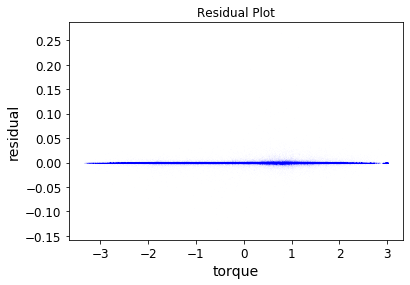

 
Summary of the model using the TEST data: 
R2 score:           0.9999455277527936
Adjusted R2 score:  0.9999455273707474
RSE score:          0.007264044856443526
 
Response variable:  pm
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
VotingRegressor(estimators=[('rfr',
                             RandomForestRegressor(n_estimators=5, n_jobs=-1,
                                                   random_state=1)),
                            ('xtr',
                             ExtraTreesRegressor(bootstrap=True, n_estimators=5,
                                                 n_jobs=-1, random_state=1)),
                            ('abr',
                             AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                                               n_estimators=5,
                                               random_state=1))],
                weights=[0.2, 0.1, 0.7])
 
Summary of the model using ALL da

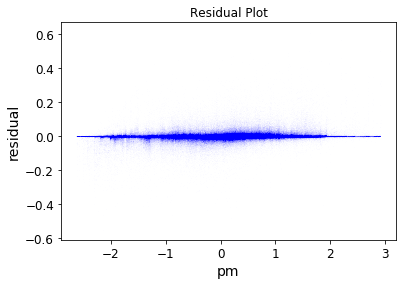

 
Summary of the model using the TEST data: 
R2 score:           0.9872602019777938
Adjusted R2 score:  0.987260112626044
RSE score:          0.11238112327480258
 
Response variable:  stator_yoke
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
VotingRegressor(estimators=[('rfr',
                             RandomForestRegressor(n_estimators=5, n_jobs=-1,
                                                   random_state=1)),
                            ('xtr',
                             ExtraTreesRegressor(bootstrap=True, n_estimators=5,
                                                 n_jobs=-1, random_state=1)),
                            ('abr',
                             AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                                               n_estimators=5,
                                               random_state=1))],
                weights=[0.2, 0.1, 0.7])
 
Summary of the model using

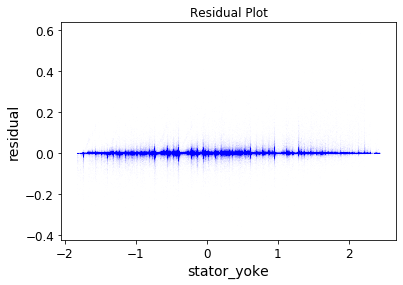

 
Summary of the model using the TEST data: 
R2 score:           0.9931123960541737
Adjusted R2 score:  0.9931123477473274
RSE score:          0.0830772203875918
 
Response variable:  stator_tooth
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
VotingRegressor(estimators=[('rfr',
                             RandomForestRegressor(n_estimators=5, n_jobs=-1,
                                                   random_state=1)),
                            ('xtr',
                             ExtraTreesRegressor(bootstrap=True, n_estimators=5,
                                                 n_jobs=-1, random_state=1)),
                            ('abr',
                             AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                                               n_estimators=5,
                                               random_state=1))],
                weights=[0.2, 0.1, 0.7])
 
Summary of the model usin

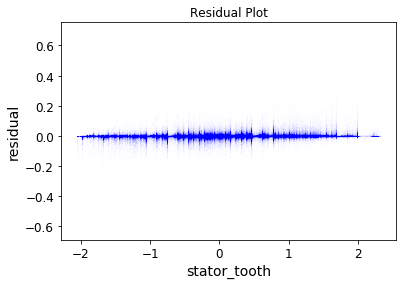

 
Summary of the model using the TEST data: 
R2 score:           0.98836996039233
Adjusted R2 score:  0.9883698788239733
RSE score:          0.10779627859637364
 
Response variable:  stator_winding
Predictor variables: 
['ambient', 'coolant', 'u_d', 'u_q', 'motor_speed', 'i_d', 'i_q']
Best estimator: 
VotingRegressor(estimators=[('rfr',
                             RandomForestRegressor(n_estimators=5, n_jobs=-1,
                                                   random_state=1)),
                            ('xtr',
                             ExtraTreesRegressor(bootstrap=True, n_estimators=5,
                                                 n_jobs=-1, random_state=1)),
                            ('abr',
                             AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),
                                               n_estimators=5,
                                               random_state=1))],
                weights=[0.2, 0.1, 0.7])
 
Summary of the model usi

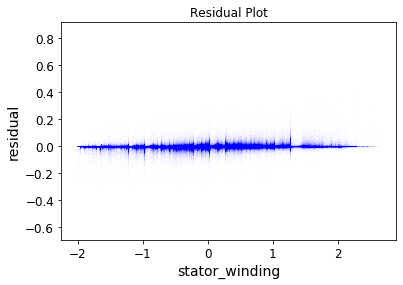

 
Summary of the model using the TEST data: 
R2 score:           0.9846278538578016
Adjusted R2 score:  0.9846277460438351
RSE score:          0.12377556210922909
 
Best model CV time :  1:05:02.599144


In [82]:
# Random forest regression, extra trees regression and adaboost regression are combined.

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor

import time, datetime

# Use a sample of the data for testing purposes. Set FRAC = 1.0 to use ALL the data.
sample_motor_data = motor_data.sample(frac = FRAC)

reg1 = RandomForestRegressor(n_estimators = 5, bootstrap = True, n_jobs = -1, random_state = 1)
reg2 = ExtraTreesRegressor(n_estimators = 5, bootstrap = True, n_jobs = -1, random_state = 1)
reg3 = AdaBoostRegressor(DecisionTreeRegressor(),n_estimators = 5, random_state = 1)

# Ensemble regressor.
params = {}
ensemble_reg = VotingRegressor([('rfr', reg1), ('xtr', reg2), ('abr', reg3)], weights = [0.2, 0.1, 0.7])

tic = time.perf_counter()
best_estimators = multiple_response_vars(sample_motor_data, ensemble_reg, params, 'GridSearchCV')
toc = time.perf_counter()
print('Tuning time : ', str(datetime.timedelta(seconds = toc-tic)))
print(' ')

# Use cross validation using the best estimators.
tic = time.perf_counter()
best_est_dict = dict(zip(response_variables, best_estimators))
cv_metrics_dict = cross_validation_metrics(sample_motor_data, best_est_dict)
#print (cv_metrics_dict)
toc = time.perf_counter()
print('Best model CV time : ', str(datetime.timedelta(seconds = toc-tic)))


populate_estimators_df(best_est_dict, cv_metrics_dict, 'EnsembleReg' )
#print(estimators_df)


In [83]:
MODEL_Subfolder = 'EnsembleReg'
save_all_models_and_results(best_est_dict, cv_metrics_dict, MODEL_Subfolder)

Saving model torque+EnsembleReg
Saving results torque+results
Saving model pm+EnsembleReg
Saving results pm+results
Saving model stator_yoke+EnsembleReg
Saving results stator_yoke+results
Saving model stator_tooth+EnsembleReg
Saving results stator_tooth+results
Saving model stator_winding+EnsembleReg
Saving results stator_winding+results


In [64]:
# Load in the saved estimators and cv metrics.
# Just need to supply the name of the subfolder.

#MODEL_Subfolder = 'EnsembleReg'
#best_estimators, cv_metrics_all = load_all_models_and_results(MODEL_Subfolder)
#print(best_estimators)
#print(cv_metrics_all)

# Code to test prediction times for the various machine learning algorithms.

# Multiple linear regression.

In [75]:
# Load in the saved estimators and cv metrics.
# Just need to supply the name of the subfolder.

MODEL_Subfolder = 'MultilinearReg'
best_estimators, cv_metrics_all = load_all_models_and_results(MODEL_Subfolder)
#print(best_estimators)
#print(cv_metrics_all)

In [77]:
import time, datetime

tic = time.perf_counter()
indx=0
for y_var in response_variables:
    tic = time.perf_counter()
    #print(best_estimators[indx])
    model=best_estimators[indx]

    # Note: ONE data point presented.
    sampledata = motor_data[:1]
    #print(sampledata)

    X_test = sampledata.loc[:,predictor_variables]
    #print(X_test)
    y =sampledata.loc[:, y_var]
    #print(y)

    y_pred = model.predict(X_test)
    #print(y_pred)
    indx=indx+1
toc = time.perf_counter()
print('Calculating time : ', str(datetime.timedelta(seconds = toc-tic)))

Calculating time :  0:00:00.004009


# Ensemble regression.

In [78]:
# Load in the saved estimators and cv metrics.
# Just need to supply the name of the subfolder.

MODEL_Subfolder = 'EnsembleReg'
best_estimators, cv_metrics_all = load_all_models_and_results(MODEL_Subfolder)
#print(best_estimators)
#print(cv_metrics_all)

In [79]:
import time, datetime

tic = time.perf_counter()
indx=0
for y_var in response_variables:
    tic = time.perf_counter()
    #print(best_estimators[indx])
    model=best_estimators[indx]

    # Note: ONE data point presented.
    sampledata = motor_data[:1]
    #print(sampledata)

    X_test = sampledata.loc[:,predictor_variables]
    #print(X_test)
    y =sampledata.loc[:, y_var]
    #print(y)

    y_pred = model.predict(X_test)
    #print(y_pred)
    indx=indx+1
toc = time.perf_counter()
print('Calculating time : ', str(datetime.timedelta(seconds = toc-tic)))

Calculating time :  0:00:00.256004
